In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# imports cell
import sys 
import matplotlib.pyplot as plt
import scipy as sp
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import _pickle as cPickle
import random, sys, keras
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize 
import scipy.integrate as it
from sklearn import preprocessing

# import tensorflow as tf
# import gc

In [3]:
# filepath = "/content/drive/My Drive/7th Term Assignments, Sheets & Labs/Modulation_classification/data/" # Yomna
filepath = "/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/data" # Arsany
# filepath = "/content/drive/MyDrive/Modulation_classification/data" # Kiro
os.chdir(filepath)

May help: https://github.com/LionAE/modulation-recognition-for-wireless-signals

2-
https://erichizdepski.wordpress.com/2019/05/23/using-machine-learning-to-categorize-radio-signals/


## **Download Data**

In [ ]:
# # you do not need to run this cell if you have an access to google drive.
# # download the dataset.
# !wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
# !tar -xf RML2016.10b.tar.bz2.1

--2020-12-31 01:59:38--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2.1’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  13.3MB/s    in 89s     

2020-12-31 02:01:08 (13.3 MB/s) - ‘RML2016.10b.tar.bz2.1’ saved [1245608913/1245608913]



# **Loading data**

In [4]:
with open('RML2016.10b.dat', 'rb') as f:
    Xd = cPickle.load(f, encoding="latin1") 
 
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    # mod is the label. mod = modulation scheme
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        #snr = signal to noise ratio
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# **Create feature Spaces**

### 1. Raw time series as given (two channels)

In [ ]:
# if want n * 2 * 128
X_raw = X[:,0], X[:,1]
X_raw = np.asarray(X_raw)
print(X_raw.shape)

(1200000, 256)


In [ ]:
# if want n * 256
X_raw = np.reshape(X_raw, (1200000,256))
print(X_raw.shape)

array([[ 0.00907056,  0.00599482, -0.0035653 , ..., -0.00607358,
        -0.0072575 , -0.00728448],
       [-0.00419709, -0.01053281, -0.00680017, ...,  0.00162549,
        -0.00118617,  0.005617  ],
       [ 0.00174664, -0.0084256 ,  0.00147178, ...,  0.00198796,
        -0.00023271,  0.00323295],
       ...,
       [ 0.0027236 ,  0.00265014,  0.00258855, ..., -0.00736364,
        -0.00733167, -0.00727415],
       [ 0.00396798,  0.00391821,  0.00399417, ..., -0.00657877,
        -0.00664485, -0.00665402],
       [ 0.00492854,  0.00492476,  0.00497359, ..., -0.00614814,
        -0.00601163, -0.0059941 ]], dtype=float32)

In [ ]:
# delete X_raw and collect garbage
del(X_raw)
gc.collect()

56

### 2. First derivative in time (two channels)

In [ ]:
# if want n * 2 * 128
X_der = np.apply_along_axis(lambda column:np.gradient(column),2,X)
X_der = np.asarray(X_der)
print(X_der.shape)

(1200000, 2, 128)


In [ ]:
# # if want n * 256
# X_der = np.reshape(X_der, (1200000,256))
# print(X_der.shape)

(1200000, 256)


In [ ]:
# # delete X_der and collect garbage
# del(X_der)
# gc.collect()

36

### 3. Integral in time (two channels)

In [ ]:
# if want n * 2 * 128
X_int = np.apply_along_axis(lambda column:np.hstack((0,column)),2,np.apply_along_axis(lambda column:sp.integrate.cumtrapz(column,dx=1,axis=-1),2,X))
X_int = np.asarray(X_int)
print(X_int.shape)

(1200000, 2, 128)


In [ ]:
# # if want n * 256
# X_int = np.reshape(X_int, (1200000,256))
# print(X_int.shape)

In [ ]:
# # delete X_int and collect garbage
# del(X_int)
# gc.collect()

0

### 4. combinations of 1,2 and 3. (More channels)

In [ ]:
# if want n * 4 * 128
com_three_X = np.concatenate((np.apply_along_axis(lambda column:np.gradient(column),2,X) ,np.apply_along_axis(lambda column:np.hstack((0,column)),2,np.apply_along_axis(lambda column:sp.integrate.cumtrapz(column,dx=1,axis=-1),2,X))),axis=1)
print(com_three_X.shape)
com_three_X = np.asarray(com_three_X)
print(com_three_X.shape)

(1200000, 4, 128)
(1200000, 4, 128)


In [ ]:
# # if want n * 512
# com_three_X = np.reshape(com_three_X, (1200000,512))

In [ ]:
# # delete com_three_X and collect garbage
# del(com_three_X)
# gc.collect()

# **Supervised Learning Step**

flatten the X train and test

In [ ]:
nsamples, nx, ny = trainX.shape
X_train = trainX.reshape((nsamples,nx*ny))

nsamples, nx, ny = testX.shape
X_test = testX.reshape((nsamples,nx*ny))

nsamples, nx, ny = valX.shape
X_val = valX.reshape((nsamples,nx*ny))

print(X_train.shape)

print(X_test.shape)

print(X_val.shape)

(798000, 256)
(360000, 256)
(42000, 256)


In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
n_examples = X.shape[0]
# looks like taking half the samples for training
n_train = int(n_examples * 0.7)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
# X_train = X[train_idx]
# X_test =  X[test_idx]

def to_onehot(yy):
    data = list(yy)
    yy1 = np.zeros([len(data), max(data)+1])
    yy1[np.arange(len(data)),data] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

(X_train, X_val, Y_train, Y_val) = train_test_split(X_train, Y_train, test_size=0.05)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(798000, 2, 128) (798000, 10)
(42000, 2, 128) (42000, 10)
(360000, 2, 128) (360000, 10)


### Classifiers

In [ ]:
# passed parameters
# X_train - X_test - X_val

# trainY_mods - trainY_snr

# testY_mods - testY_snr

# valY_mods - valY_snr

Logistic Regression Classifier

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

logistic_regression = LogisticRegression(max_iter=1000)
scaler = MinMaxScaler()
normalized_X_train = scaler.fit_transform(X_train)
normalized_X_test = scaler.transform(X_test)
normalized_X_val = scaler.transform(X_val)
logistic_regression_model = logistic_regression.fit(normalized_X_train, trainY_mods)

In [ ]:
import pickle
pickle.dump(logistic_regression_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/logistic_regression.sav', 'wb'))

# loaded_model = pickle.load(open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/logistic_regression.sav', 'rb'))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

SNR =  -20

Accuracy =  0.10256979519342843
Train Accuracy =  0.11099400235890487
Validation Accuracy =  0.09044048734770384
SNR =  -18

Accuracy =  0.10448010698762955
Train Accuracy =  0.11239164203036528
Validation Accuracy =  0.08644859813084112
SNR =  -16

Accuracy =  0.10377305913169481
Train Accuracy =  0.1156496554479177
Validation Accuracy =  0.10773067331670823
SNR =  -14

Accuracy =  0.10491382676111329
Train Accuracy =  0.11780465209444403
Validation Accuracy =  0.09896810506566604
SNR =  -12

Accuracy =  0.11477499445799158
Train Accuracy =  0.12919273385090826
Validation Accuracy =  0.10951276102088167
SNR =  -10

Accuracy =  0.14311967477863785
Train Accuracy =  0.1559120945134161
Validation Accuracy =  0.09995217599234815
SNR =  -8

Accuracy =  0.17631739347259934
Train Accuracy =  0.18679996993159437
Validation Accuracy =  0.09784735812133072
SNR =  -6

Accuracy =  0.18837863167760074
Train Accuracy =  0.19243925750792293
Validation Accuracy =  0.10175939134569663
SNR 

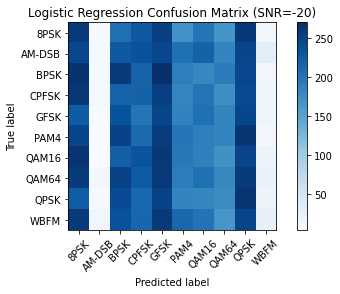

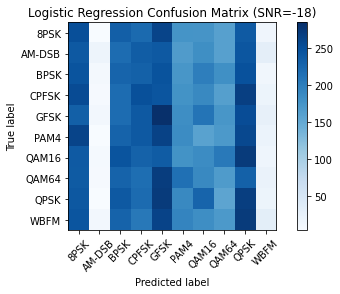

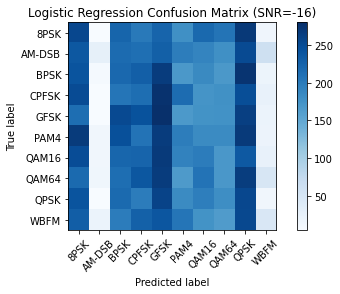

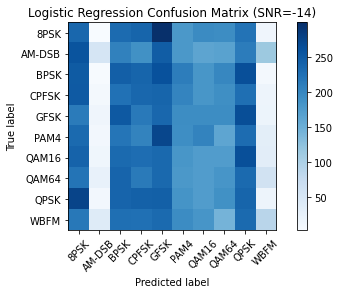

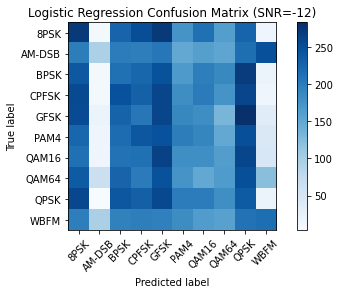

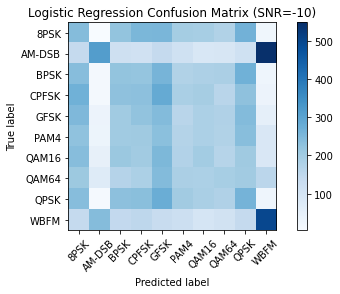

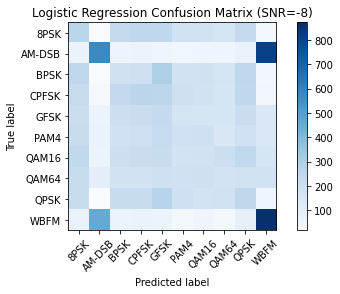

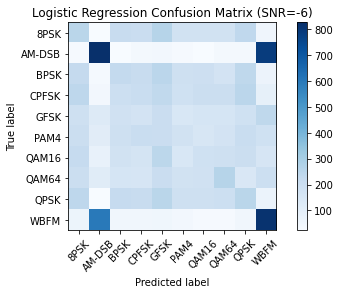

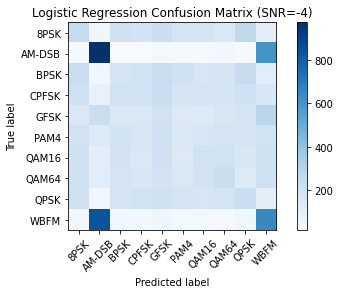

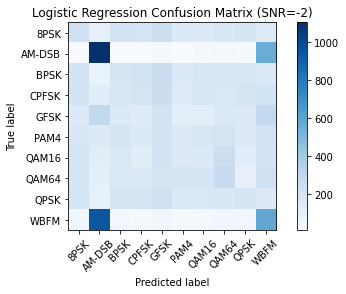

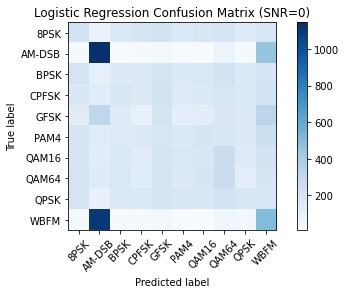

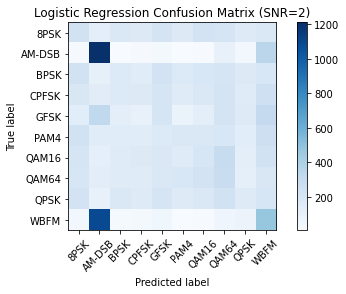

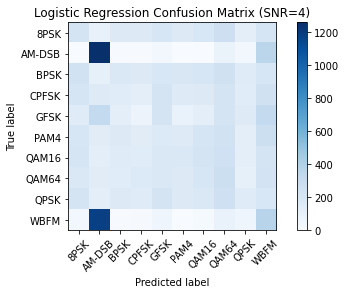

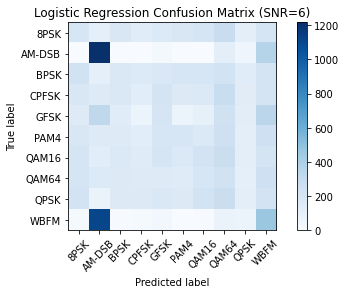

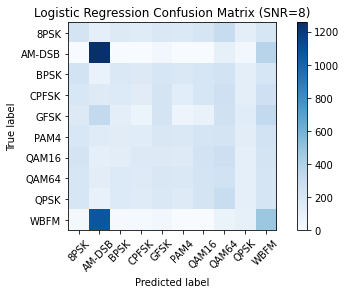

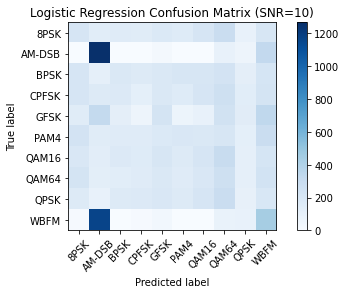

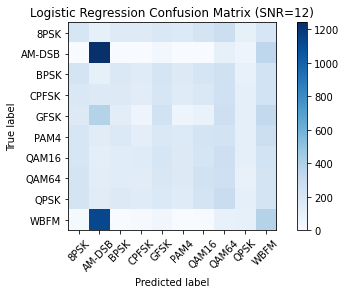

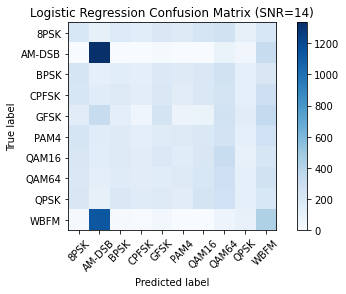

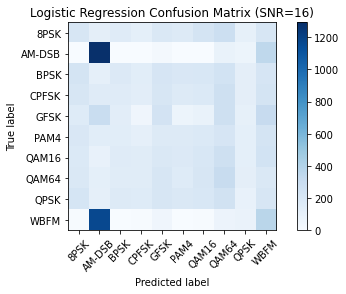

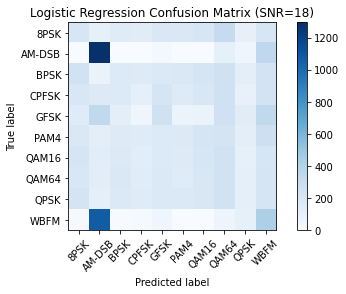

In [ ]:
acc = []
tr_acc = []
val_acc = []
for snr in snrs:
  print("SNR = ", snr)
  #test accuracy
  normalized_X_test_i = normalized_X_test[np.where(testY_snr == str(snr))]
  testY_mods_i = testY_mods[np.where(testY_snr == str(snr))]

  y_pred = logistic_regression_model.predict(normalized_X_test_i)
  accuracy = accuracy_score(y_pred, testY_mods_i)
  acc.append(accuracy)
  print("\nAccuracy = ", accuracy)

  #train accuracy
  normalized_X_train_i = normalized_X_train[np.where(trainY_snr == str(snr))]
  trainY_mods_i = trainY_mods[np.where(trainY_snr == str(snr))]

  y_pred_train = logistic_regression_model.predict(normalized_X_train_i)
  train_accuracy = accuracy_score(y_pred_train, trainY_mods_i)
  tr_acc.append(train_accuracy)
  print("Train Accuracy = ", train_accuracy)

  #validation accuracy
  X_val_i = X_val[np.where(valY_snr == str(snr))]
  valY_mods_i = valY_mods[np.where(valY_snr == str(snr))]

  y_pred_val = logistic_regression_model.predict(X_val_i)
  val_accuracy = accuracy_score(y_pred_val, valY_mods_i)
  val_acc.append(val_accuracy)
  print("Validation Accuracy = ", val_accuracy)

  conf = confusion_matrix(testY_mods_i, y_pred)
  plt.figure()
  plot_confusion_matrix(conf, labels=mods, title="Logistic Regression Confusion Matrix (SNR=%d)"%(snr))

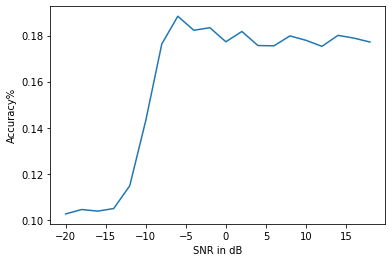

In [ ]:
# Plot the data
plt.plot(snrs, acc)
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy%')
# Show the plot
plt.show()

Decision ​ Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

decision_tree = DecisionTreeClassifier()
# scaler = MinMaxScaler()
# normalized_X_train = scaler.fit_transform(X_train)
# normalized_X_test = scaler.transform(X_test)
# normalized_X_val = scaler.transform(X_val)
decision_tree_model = decision_tree.fit(X_train, trainY_mods)

In [ ]:
import pickle
pickle.dump(decision_tree_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/decision_tree.sav', 'wb'))

# loaded_model = pickle.load(open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/decision_tree.sav', 'rb'))

SNR =  -20

Accuracy =  0.10029758624490245
Train Accuracy =  1.0
Validation Accuracy =  0.10503597122302158
SNR =  -18

Accuracy =  0.102695193109197
Train Accuracy =  1.0
Validation Accuracy =  0.09561200923787529
SNR =  -16

Accuracy =  0.10010410388471865
Train Accuracy =  1.0
Validation Accuracy =  0.09962049335863378
SNR =  -14

Accuracy =  0.1022658024486178
Train Accuracy =  1.0
Validation Accuracy =  0.10286519492719587
SNR =  -12

Accuracy =  0.10619615639496355
Train Accuracy =  1.0
Validation Accuracy =  0.0976926853215513
SNR =  -10

Accuracy =  0.11372374212960383
Train Accuracy =  1.0
Validation Accuracy =  0.12398276687410244
SNR =  -8

Accuracy =  0.12756276724043417
Train Accuracy =  1.0
Validation Accuracy =  0.11342069588793494
SNR =  -6

Accuracy =  0.14405829596412556
Train Accuracy =  1.0
Validation Accuracy =  0.15009293680297398
SNR =  -4

Accuracy =  0.18362533692722371
Train Accuracy =  1.0
Validation Accuracy =  0.18034398034398033
SNR =  -2

Accuracy =  0.2

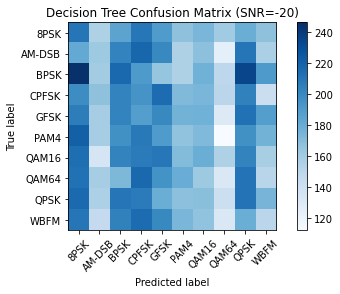

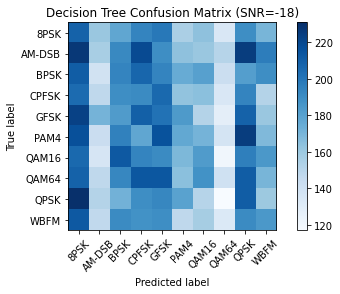

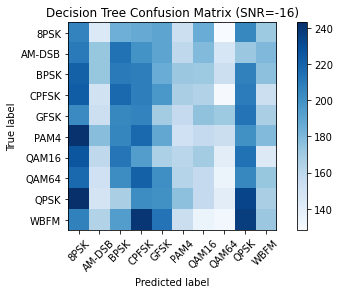

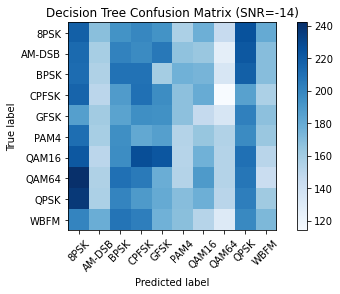

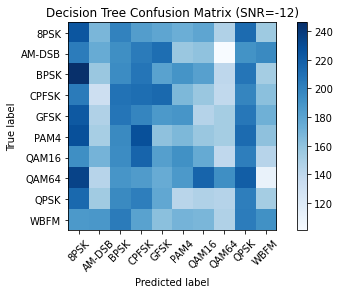

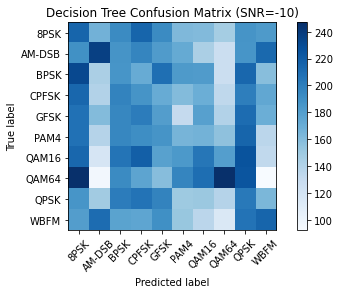

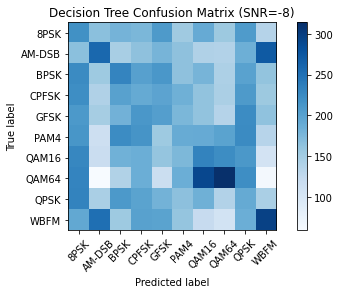

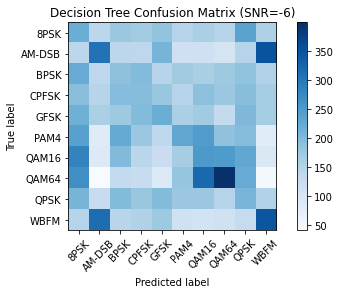

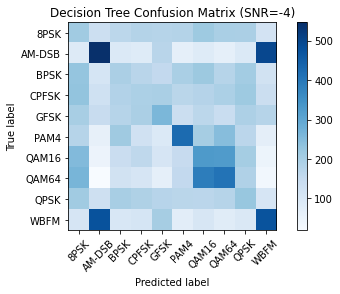

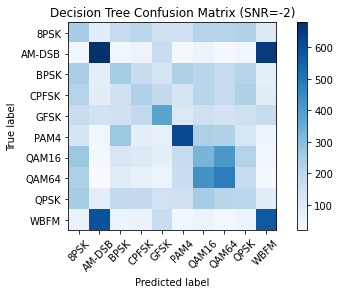

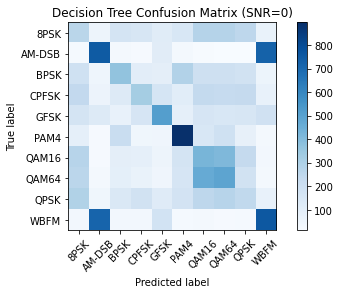

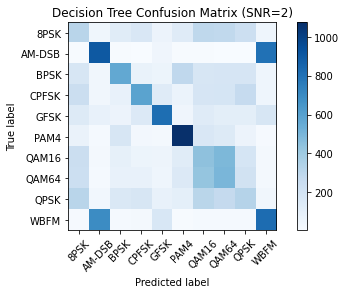

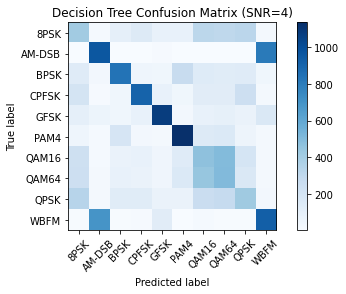

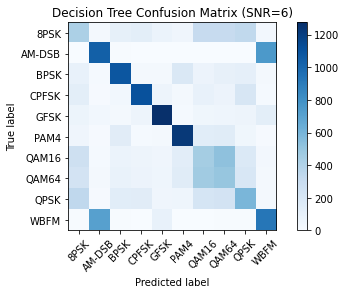

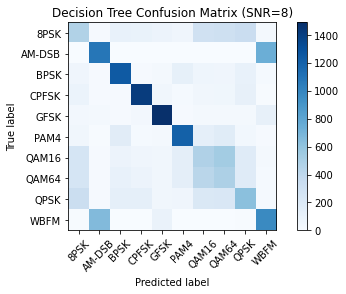

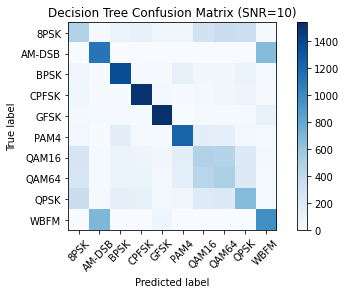

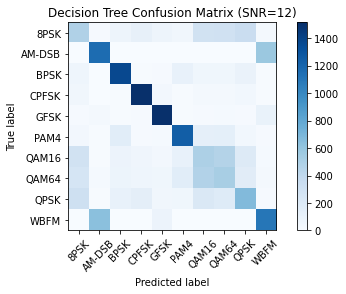

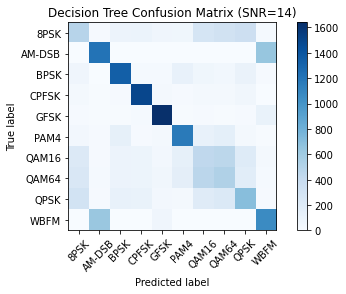

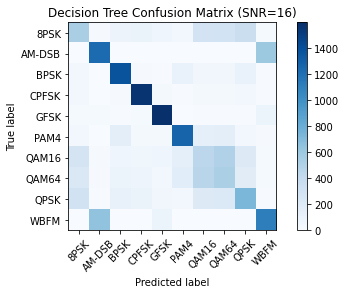

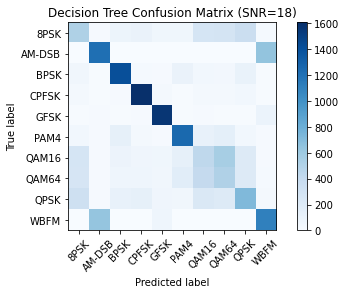

In [ ]:
acc = []
tr_acc = []
val_acc = []
for snr in snrs:
  print("SNR = ", snr)
  #test accuracy
  X_test_i = X_test[np.where(testY_snr == str(snr))]
  testY_mods_i = testY_mods[np.where(testY_snr == str(snr))]

  y_pred = decision_tree_model.predict(X_test_i)
  accuracy = accuracy_score(y_pred, testY_mods_i)
  acc.append(accuracy)
  print("\nAccuracy = ", accuracy)

  #train accuracy
  X_train_i = X_train[np.where(trainY_snr == str(snr))]
  trainY_mods_i = trainY_mods[np.where(trainY_snr == str(snr))]

  y_pred_train = decision_tree_model.predict(X_train_i)
  train_accuracy = accuracy_score(y_pred_train, trainY_mods_i)
  tr_acc.append(train_accuracy)
  print("Train Accuracy = ", train_accuracy)

  #validation accuracy
  X_val_i = X_val[np.where(valY_snr == str(snr))]
  valY_mods_i = valY_mods[np.where(valY_snr == str(snr))]

  y_pred_val = decision_tree_model.predict(X_val_i)
  val_accuracy = accuracy_score(y_pred_val, valY_mods_i)
  val_acc.append(val_accuracy)
  print("Validation Accuracy = ", val_accuracy)

  conf = confusion_matrix(testY_mods_i, y_pred)
  plt.figure()
  plot_confusion_matrix(conf, labels=mods, title="Decision Tree Confusion Matrix (SNR=%d)"%(snr))

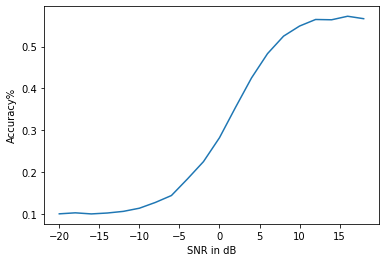

In [ ]:
# Plot the data
plt.plot(snrs, acc)
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy%')
# Show the plot
plt.show()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 50, n_jobs=1)
random_forest_model = random_forest.fit(X_train, trainY_mods)

In [ ]:
import pickle
pickle.dump(random_forest_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/random_forest.sav', 'wb'))

# random_forest_model = pickle.load(open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/random_forest.sav', 'rb'))

SNR =  -20

Accuracy =  0.09869943789264851
Train Accuracy =  1.0
Validation Accuracy =  0.10119904076738609
SNR =  -18

Accuracy =  0.10486246179494305
Train Accuracy =  1.0
Validation Accuracy =  0.09792147806004618
SNR =  -16

Accuracy =  0.10448742534655635
Train Accuracy =  1.0
Validation Accuracy =  0.1062618595825427
SNR =  -14

Accuracy =  0.11079718575148191
Train Accuracy =  1.0
Validation Accuracy =  0.09581963363081258
SNR =  -12

Accuracy =  0.11735144687430969
Train Accuracy =  1.0
Validation Accuracy =  0.11929307805596466
SNR =  -10

Accuracy =  0.13801749596032764
Train Accuracy =  1.0
Validation Accuracy =  0.13882240306366683
SNR =  -8

Accuracy =  0.18084639842122574
Train Accuracy =  1.0
Validation Accuracy =  0.17306823316764572
SNR =  -6

Accuracy =  0.24915919282511212
Train Accuracy =  1.0
Validation Accuracy =  0.2537174721189591
SNR =  -4

Accuracy =  0.31446540880503143
Train Accuracy =  1.0
Validation Accuracy =  0.31105651105651105
SNR =  -2

Accuracy =  0

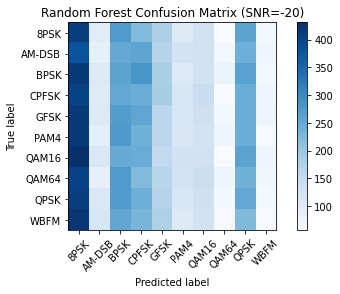

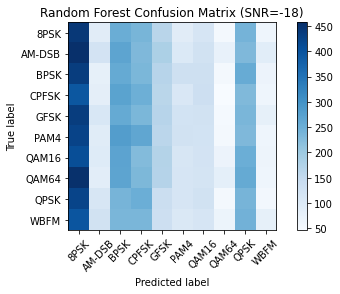

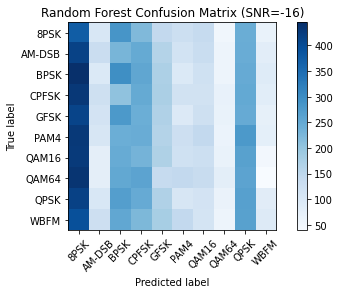

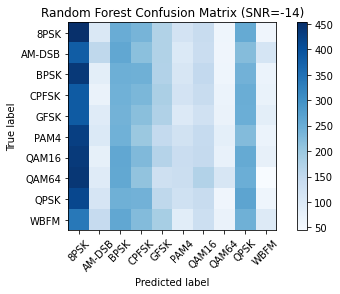

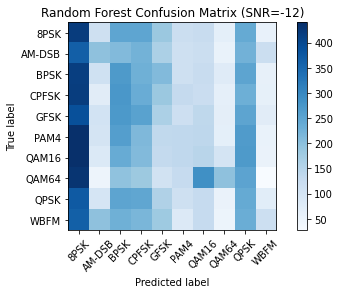

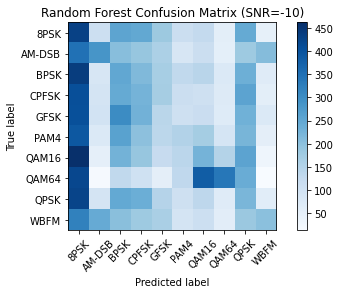

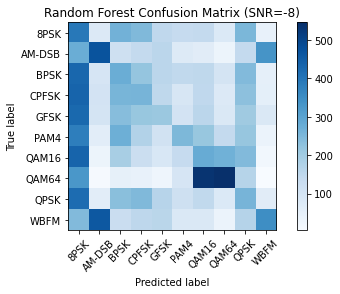

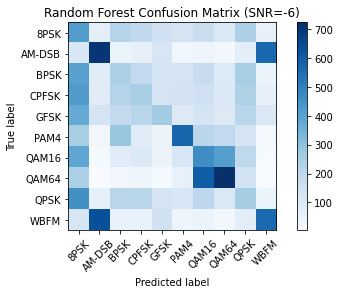

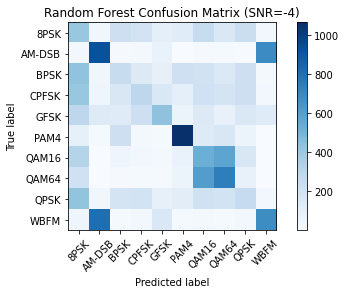

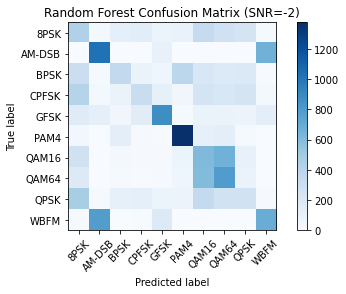

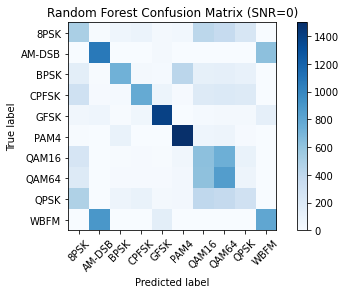

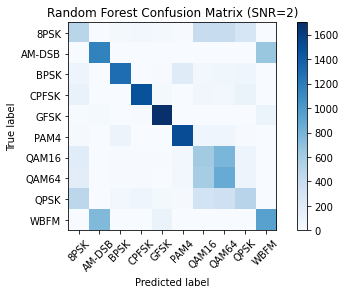

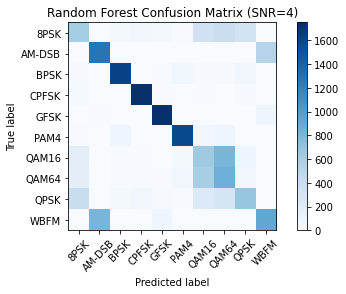

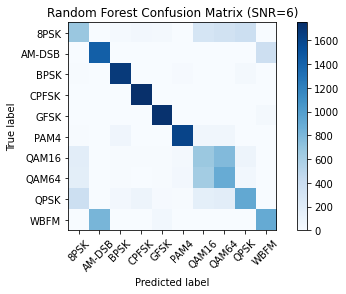

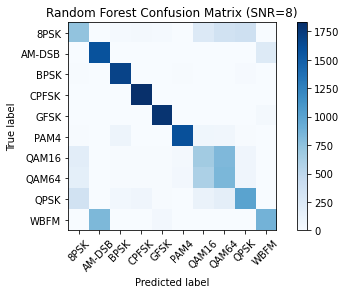

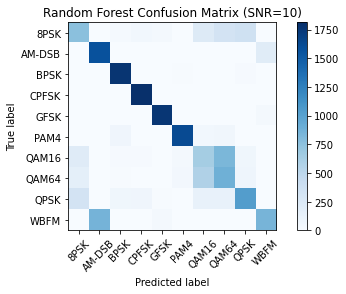

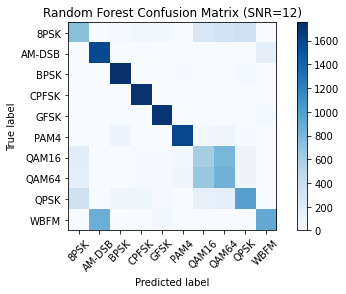

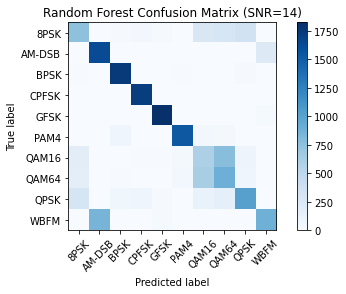

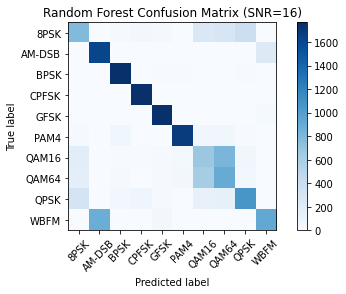

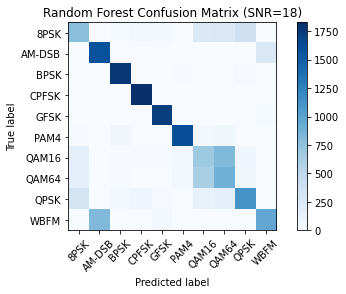

In [ ]:
acc = []
tr_acc = []
val_acc = []
for snr in snrs:
  print("SNR = ", snr)
  #test accuracy
  X_test_i = X_test[np.where(testY_snr == str(snr))]
  testY_mods_i = testY_mods[np.where(testY_snr == str(snr))]

  y_pred = random_forest_model.predict(X_test_i)
  accuracy = accuracy_score(y_pred, testY_mods_i)
  acc.append(accuracy)
  print("\nAccuracy = ", accuracy)

  #train accuracy
  X_train_i = X_train[np.where(trainY_snr == str(snr))]
  trainY_mods_i = trainY_mods[np.where(trainY_snr == str(snr))]

  y_pred_train = random_forest_model.predict(X_train_i)
  train_accuracy = accuracy_score(y_pred_train, trainY_mods_i)
  tr_acc.append(train_accuracy)
  print("Train Accuracy = ", train_accuracy)

  #validation accuracy
  X_val_i = X_val[np.where(valY_snr == str(snr))]
  valY_mods_i = valY_mods[np.where(valY_snr == str(snr))]

  y_pred_val = random_forest_model.predict(X_val_i)
  val_accuracy = accuracy_score(y_pred_val, valY_mods_i)
  val_acc.append(val_accuracy)
  print("Validation Accuracy = ", val_accuracy)

  conf = confusion_matrix(testY_mods_i, y_pred)
  plt.figure()
  plot_confusion_matrix(conf, labels=mods, title="Random Forest Confusion Matrix (SNR=%d)"%(snr))

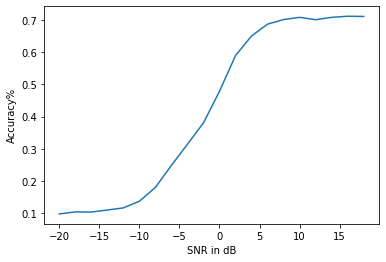

In [ ]:
# Plot the data
plt.plot(snrs, acc)
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy%')
# Show the plot
plt.show()

In [ ]:
print("trainX.shape", trainX.shape)
print("testX.shape", testX.shape)
print("valX.shape", valX.shape)
print("trainy.shape", trainY.shape)
print("testy.shape", testY.shape)
print("valy.shape", valY.shape)

trainX.shape (798000, 2, 128)
testX.shape (360000, 2, 128)
valX.shape (42000, 2, 128)
trainy.shape (798000, 2)
testy.shape (360000, 2)
valy.shape (42000, 2)


# Start

**Get features**

In [5]:
def getFeatures(version): # 1, 2, 3 or 4
  if (version == 1):
      # X_raw = X[:,0], X[:,1]
      # X_raw = np.asarray(X_raw)
      return X
  elif (version == 2):
      X_der = np.apply_along_axis(lambda column:np.gradient(column),2,X)
      X_der = np.asarray(X_der)  
      return X_der
  elif (version == 3):
      X_int = np.apply_along_axis(lambda column:np.hstack((0,column)),2,np.apply_along_axis(lambda column:sp.integrate.cumtrapz(column,dx=1,axis=-1),2,X))
      X_int = np.asarray(X_int)  
      return X_int
  elif (version == 4):
      com_three_X = np.concatenate((np.apply_along_axis(lambda column:np.gradient(column),2,X) ,np.apply_along_axis(lambda column:np.hstack((0,column)),2,np.apply_along_axis(lambda column:sp.integrate.cumtrapz(column,dx=1,axis=-1),2,X))),axis=1)
      print(com_three_X.shape)
      com_three_X = np.asarray(com_three_X)
      print(com_three_X.shape)
      return com_three_X
  else :
      print("Error:this version doesn't exist")
      return X


**Splitting Data**

In [6]:
def split_data(XIn,YIn):
  Y = np.array(YIn)
  (trainX, testX, trainY, testY) = train_test_split(XIn,Y, test_size=0.3)
  (trainX, valX, trainY, valY) = train_test_split(trainX,trainY, test_size=0.05)

  lb = preprocessing.LabelBinarizer()
  trainY_mods, trainY_snr = zip(*trainY)
  testY_mods, testY_snr = zip(*testY)
  valY_mods, valY_snr = zip(*valY)

  trainY_mods = np.array(trainY_mods)
  trainY_mod10 = lb.fit_transform(trainY_mods)

  trainY_snr = np.array(trainY_snr)
  testY_mods = np.array(testY_mods)
  testY_mod10 = lb.fit_transform(testY_mods)
  testY_snr = np.array(testY_snr)
  valY_mods = np.array(valY_mods)
  valY_mod10 = lb.fit_transform(valY_mods)
  valY_snr = np.array(valY_snr)

  return trainX, trainY_snr, trainY_mods, trainY_mod10, valX, valY_snr, valY_mods, valY_mod10, testX, testY_snr, testY_mods, testY_mod10

**Flatten Data**

In [7]:
def flatten(trainX, testX, valX):
  
  nsamples, nx, ny = trainX.shape
  X_train = trainX.reshape((nsamples,nx*ny))

  nsamples, nx, ny = testX.shape
  X_test = testX.reshape((nsamples,nx*ny))

  nsamples, nx, ny = valX.shape
  X_val = valX.reshape((nsamples,nx*ny))

  return X_train, X_test, X_val

In [8]:
# change the number for the data you want 1, 2 or 3
trainX, trainY_snr, trainY_mods, trainY_mod10, valX, valY_snr, valY_mods, valY_mod10, testX, testY_snr, testY_mods, testY_mod10 = split_data(getFeatures(1),lbl)
# delete X you work on and collect garbage
del(X)
gc.collect()
X_train, X_test, X_val = flatten(trainX, testX, valX)


# Functions

**Confusion Matrix plotting**

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

**SNRs Plotting**

In [10]:
def snr_plot(acc, snrs):
  # Plot the data
  plt.plot(snrs, acc)
  plt.xlabel('SNR in dB')
  plt.ylabel('Accuracy%')
  # Show the plot
  plt.show()


**Calculating accuracy for each snr**

In [11]:
def calculatingAcc(model,Xtr,Xte,Xva,shape):
  acc = []
  tr_acc = []
  val_acc = []
  for snr in snrs:
    print("\nSNR = ", snr)
    #test accuracy
    normalized_X_test_i = Xte[np.where(testY_snr == str(snr))]
    testY_mods_i = testY_mods[np.where(testY_snr == str(snr))]
    trainY_mods_i = trainY_mods[np.where(trainY_snr == str(snr))]
    valY_mods_i = valY_mods[np.where(valY_snr == str(snr))]
    y_pred = model.predict(normalized_X_test_i)
    if (shape == 10):
        testY_mods_i = testY_mod10[np.where(testY_snr == str(snr))]
        trainY_mods_i = trainY_mod10[np.where(trainY_snr == str(snr))]
        valY_mods_i = valY_mod10[np.where(valY_snr == str(snr))]
        testY_mods_i = np.argmax(testY_mods_i, axis=1)
        y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_pred, testY_mods_i)
    acc.append(accuracy)
    print("Accuracy = ", accuracy)

    #train accuracy
    normalized_X_train_i = Xtr[np.where(trainY_snr == str(snr))]
    y_pred_train = model.predict(normalized_X_train_i)

    if (shape == 10):
      trainY_mods_i = np.argmax(trainY_mods_i, axis=1)
      y_pred_train = np.argmax(y_pred_train, axis=1)

    train_accuracy = accuracy_score(y_pred_train, trainY_mods_i)
    tr_acc.append(train_accuracy)
    print("Train Accuracy = ", train_accuracy)

    #validation accuracy
    X_val_i = Xva[np.where(valY_snr == str(snr))]
    y_pred_val = model.predict(X_val_i)

    if (shape == 10):
      valY_mods_i = np.argmax(valY_mods_i, axis=1)
      y_pred_val = np.argmax(y_pred_val, axis=1)

    val_accuracy = accuracy_score(y_pred_val, valY_mods_i)
    val_acc.append(val_accuracy)
    print("Validation Accuracy = ", val_accuracy)
    print("Avarege Overall Accuracy = ", (val_accuracy+train_accuracy+accuracy)/3)
    conf = confusion_matrix(testY_mods_i, y_pred)
    plt.figure()
    plot_confusion_matrix(conf, labels=mods, title="Confusion Matrix (SNR=%d)"%(snr))
  return acc

# **Functions of Classifiers**

**Logistic Regression**

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

def log_reg_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr):  
  
  #logistic regression classifier
  logistic_regression = LogisticRegression(max_iter=1000)
  scaler = MinMaxScaler()
  normalized_X_train = scaler.fit_transform(X_train)
  normalized_X_test = scaler.transform(X_test)
  normalized_X_val = scaler.transform(X_val)
  logistic_regression_model = logistic_regression.fit(normalized_X_train, trainY_mods)

  #save model
  # pickle.dump(logistic_regression_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/logistic_regression(feature_typexxxx).sav', 'wb'))

  acc = calculatingAcc(logistic_regression_model,normalized_X_train,normalized_X_test,normalized_X_val,0)
  return acc

**Decision Tree**

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

def decision_tree_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr):

  #Decision Tree classifier
  decision_tree = DecisionTreeClassifier()
  decision_tree_model = decision_tree.fit(X_train, trainY_mods)

  #save model
  # pickle.dump(decision_tree_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/decision_tree(feature_typexxxx).sav', 'wb'))

  acc = calculatingAcc(decision_tree_model,X_train,X_test,X_val,0)
  return acc

**Random Forest**

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

def random_forest_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr):

  #random forest classifier
  random_forest = RandomForestClassifier(n_estimators = 50, n_jobs=1)
  random_forest_model = random_forest.fit(X_train, trainY_mods)

  #save model
  # pickle.dump(decision_tree_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/random_forest(feature_typexxxx).sav', 'wb'))

  acc = calculatingAcc(random_forest_model,X_train,X_test,X_val,0)
  return acc

**Fully Connetced Dense Layer**

In [15]:
def full_dense(X_train, trainY_mod10, X_val, valY_mod10, X_test):

  in_shp = list(X_train.shape[1:])
  model = models.Sequential()
  model.add(Dense(128, activation ='relu', input_shape = in_shp))
  model.add(Flatten())
  model.add(Dense(10, activation ='softmax'))

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])

  print("Model summary for this input: ")  
  model.summary()
  
  nb_epoch = 100     # number of epochs to train on
  batch_size = 1024  # training batch size
  
  print("Start training for model: ")
  history = model.fit(X_train,
      trainY_mod10,
      batch_size = batch_size,
      epochs = nb_epoch,
      verbose = 2,
      validation_data = (X_val, valY_mod10),
      callbacks = [
          keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
      ])
  print("Training End")

  plt.figure(1)
  plt.title('Training performance')
  plt.plot(history.epoch, history.history['loss'], label='train loss+error')
  plt.plot(history.epoch, history.history['val_loss'], label='val_error')
  plt.legend()

  plt.figure(2)
  acc = calculatingAcc(model, X_train, X_test, X_val, 10)
  snr_plot(acc, snrs)

**CNN Model**

**Function to create model**

In [22]:

def CnnModel(X_trainIn,Y_trainIn,X_valIn,Y_valIn,X_testIn,Y_testIn):
  in_shp = list(X_trainIn.shape[1:])
  dr = 0.5
  # [(W−K+2P)/S]+1
  model = models.Sequential()
  # input 2 * 128
  model.add(Reshape([1]+in_shp, input_shape=in_shp))
  # model.add(ZeroPadding2D((0, 2)))
  # ConvLayer1 64 * 1 * 3
  model.add(Conv2D(64, (1, 3), activation="relu", name="conv1",  padding="valid",data_format = 'channels_first', kernel_initializer="glorot_uniform"))
  model.add(Dropout(dr))
  # model.add(ZeroPadding2D((0, 2)))
  # ConvLayer2 16 * 2 * 3
  model.add(Conv2D(16, (2, 3), activation="relu", name="conv2", padding="valid",data_format = 'channels_first',  kernel_initializer="glorot_uniform"))
  model.add(Dropout(dr))
  model.add(Flatten())
  # Dense Layer 128
  model.add(Dense(128, activation="relu", name="dense1", kernel_initializer="he_normal"))
  model.add(Dropout(dr))
  # Dense Layer 10
  model.add(Dense(10,activation='softmax', name="dense2", kernel_initializer="he_normal"))
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  model.build(X_trainIn.shape) 
  print("Model summary for this input: ")                         
  model.summary()
  nb_epoch = 100     # number of epochs to train on
  batch_size = 1024  # training batch size
  filepath = 'models/cnnmodel.h5'
  print("Start training for model: ")
  history = model.fit(X_trainIn,
      Y_trainIn,
      batch_size=batch_size,
      epochs=nb_epoch,
      verbose=2,
      validation_data=(X_valIn, Y_valIn),
      callbacks = [
          keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
      ])
  print("Training End")
  print("Scores :")
  score1 = model.evaluate(X_trainIn, Y_trainIn, verbose=0, batch_size=batch_size)
  score2 = model.evaluate(X_valIn, Y_valIn, verbose=0, batch_size=batch_size)
  score3 = model.evaluate(X_testIn, Y_testIn, verbose=0, batch_size=batch_size)
  print("Train = ",score1)
  print("Validation = ",score2)
  print("Test = ",score3)
  print("Trainig Performance :")
  plt.figure(1)
  plt.title('Training performance')
  plt.plot(history.epoch, history.history['loss'], label='train loss+error')
  plt.plot(history.epoch, history.history['val_loss'], label='val_error')
  plt.legend()
  plt.figure(2)
  acc = calculatingAcc(model,X_trainIn,X_testIn,X_valIn,10)
  snr_plot(acc, snrs)
  return

# **Training Classifiers**

In [ ]:
# # trainX, testX, valX, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr = split_data(com_three_X, lbl)
# trainX, trainY_snr, trainY_mods, trainY_mod10, valX, valY_snr, valY_mods, valY_mod10, testX, testY_snr, testY_mods, testY_mod10 = getSplitedData(getFeatures(2),lbl)
# X_train, X_test, X_val = flatten(trainX, testX, valX)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



SNR =  -20
Accuracy =  0.09947353837628152
Train Accuracy =  0.11113060917523189
Validation Accuracy =  0.1036319612590799
Avarege Overall Accuracy =  0.1047453696035311


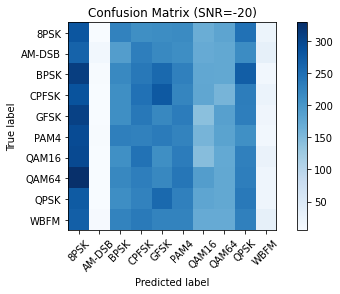


SNR =  -18
Accuracy =  0.10163492331029833
Train Accuracy =  0.11297363366509516
Validation Accuracy =  0.10321969696969698
Avarege Overall Accuracy =  0.10594275131503016


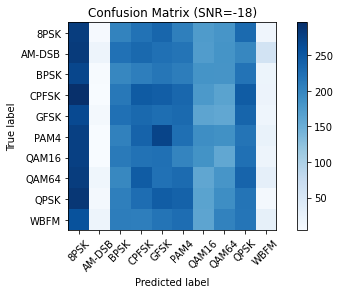


SNR =  -16
Accuracy =  0.10231226849253564
Train Accuracy =  0.11513518906515015
Validation Accuracy =  0.10861244019138756
Avarege Overall Accuracy =  0.10868663258302445


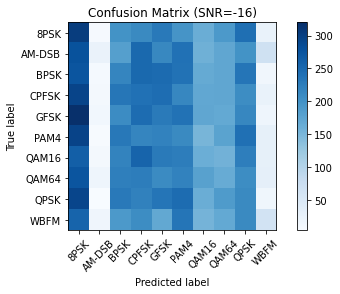


SNR =  -14
Accuracy =  0.10608734009704456
Train Accuracy =  0.11802056037089297
Validation Accuracy =  0.10891544117647059
Avarege Overall Accuracy =  0.11100778054813604


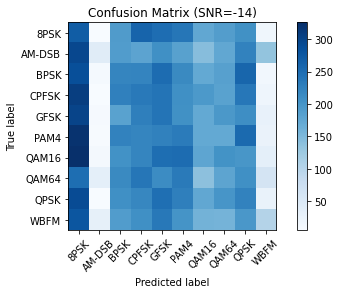


SNR =  -12
Accuracy =  0.11383237505528528
Train Accuracy =  0.12945586274559132
Validation Accuracy =  0.11707542804257288
Avarege Overall Accuracy =  0.12012122194781649


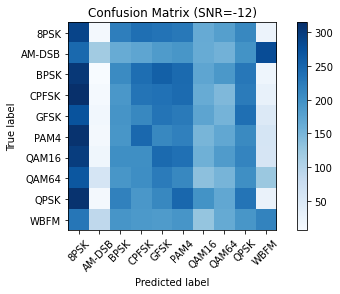


SNR =  -10
Accuracy =  0.14400044154983993
Train Accuracy =  0.1544962897748711
Validation Accuracy =  0.14480488951574988
Avarege Overall Accuracy =  0.1477672069468203


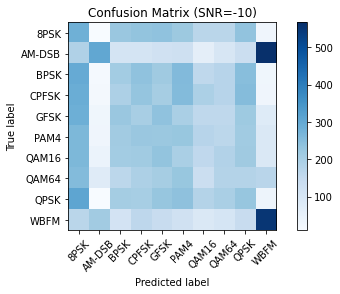


SNR =  -8
Accuracy =  0.17327777777777778
Train Accuracy =  0.18554011339119963
Validation Accuracy =  0.1716557530402245
Avarege Overall Accuracy =  0.176824548069734


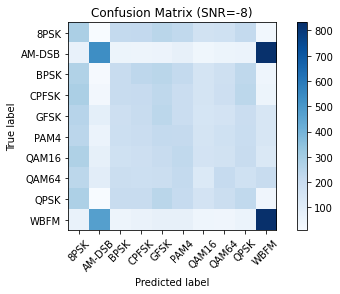


SNR =  -6
Accuracy =  0.18660287081339713
Train Accuracy =  0.19094596624768392
Validation Accuracy =  0.1728927203065134
Avarege Overall Accuracy =  0.1834805191225315


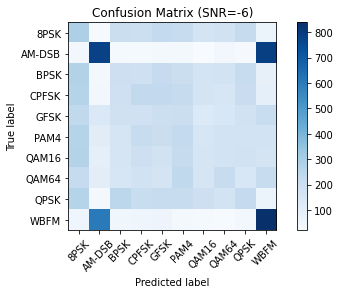


SNR =  -4
Accuracy =  0.18408289241622575
Train Accuracy =  0.19501709573612228
Validation Accuracy =  0.17596153846153847
Avarege Overall Accuracy =  0.1850205088712955


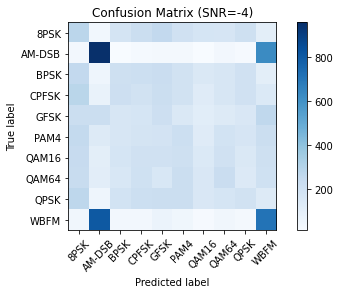


SNR =  -2
Accuracy =  0.18696616749861342
Train Accuracy =  0.1892122428499749
Validation Accuracy =  0.1943127962085308
Avarege Overall Accuracy =  0.19016373551903973


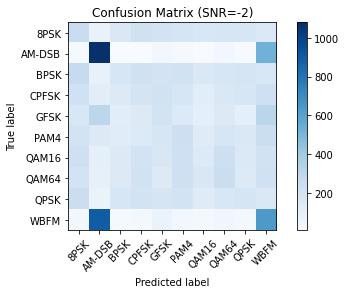


SNR =  0
Accuracy =  0.18014192322735653
Train Accuracy =  0.18945
Validation Accuracy =  0.1844983357108892
Avarege Overall Accuracy =  0.18469675297941524


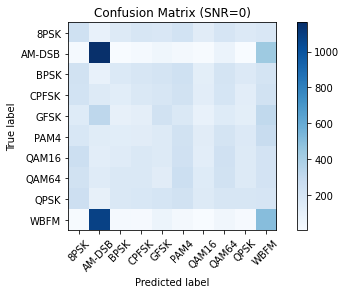


SNR =  2
Accuracy =  0.18599501799058954
Train Accuracy =  0.18765686176086738
Validation Accuracy =  0.18603538976566236
Avarege Overall Accuracy =  0.18656242317237312


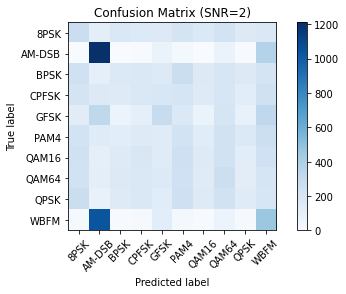


SNR =  4
Accuracy =  0.18198549916341328
Train Accuracy =  0.18930072028811526
Validation Accuracy =  0.16778523489932887
Avarege Overall Accuracy =  0.17969048478361915


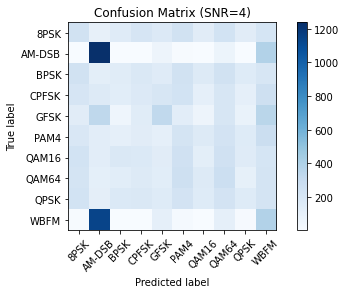


SNR =  6
Accuracy =  0.1806260811338653
Train Accuracy =  0.1911014405762305
Validation Accuracy =  0.1928400954653938
Avarege Overall Accuracy =  0.1881892057251632


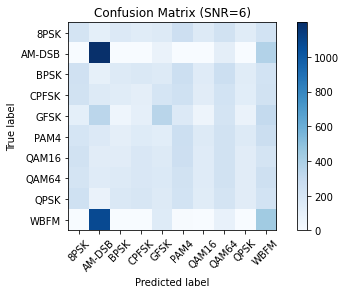


SNR =  8
Accuracy =  0.18452050227803088
Train Accuracy =  0.19071039622594163
Validation Accuracy =  0.18131101813110181
Avarege Overall Accuracy =  0.18551397221169144


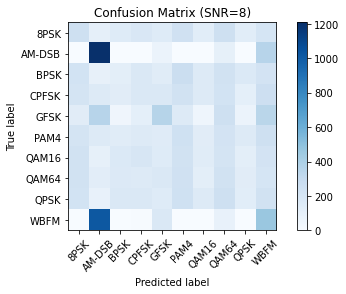


SNR =  10
Accuracy =  0.18801286316256377
Train Accuracy =  0.19032679082375384
Validation Accuracy =  0.18991517436380773
Avarege Overall Accuracy =  0.18941827611670847


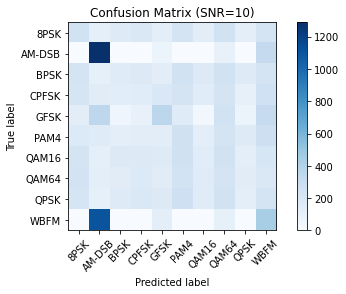


SNR =  12
Accuracy =  0.18441500363351782
Train Accuracy =  0.189392993582861
Validation Accuracy =  0.18962172647914646
Avarege Overall Accuracy =  0.1878099078985084


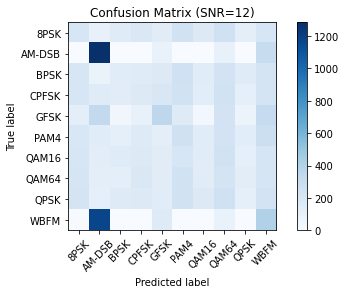


SNR =  14
Accuracy =  0.1912571364603157
Train Accuracy =  0.19318692288495135
Validation Accuracy =  0.1937984496124031
Avarege Overall Accuracy =  0.19274750298589005


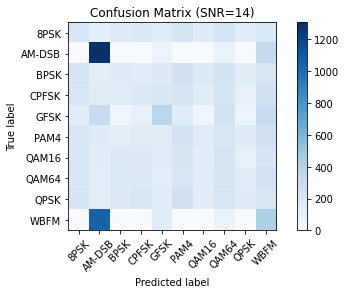


SNR =  16
Accuracy =  0.188962008516286
Train Accuracy =  0.18619928789930296
Validation Accuracy =  0.19852579852579852
Avarege Overall Accuracy =  0.19122903164712915


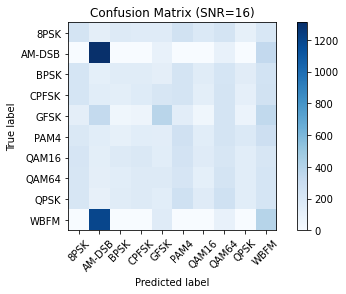


SNR =  18
Accuracy =  0.18647800473490062
Train Accuracy =  0.18649008619606464
Validation Accuracy =  0.1952054794520548
Avarege Overall Accuracy =  0.18939119012767336


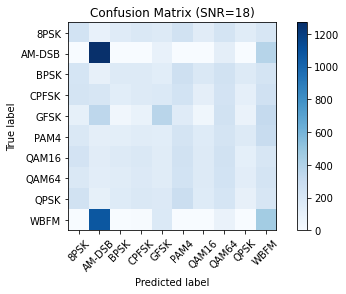

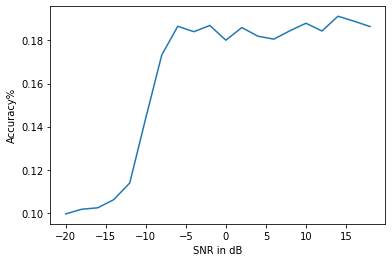

In [17]:
acc = log_reg_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr)
snr_plot(acc, snrs)


SNR =  -20
Accuracy =  0.09758935993349958
Train Accuracy =  1.0
Validation Accuracy =  0.11041162227602906
Avarege Overall Accuracy =  0.40266699406984285


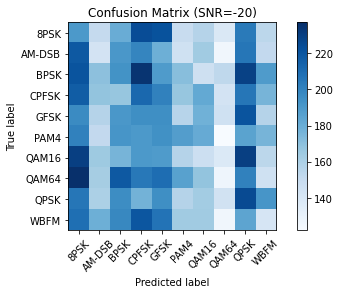


SNR =  -18
Accuracy =  0.09921905725040733
Train Accuracy =  1.0
Validation Accuracy =  0.10369318181818182
Avarege Overall Accuracy =  0.4009707463561964


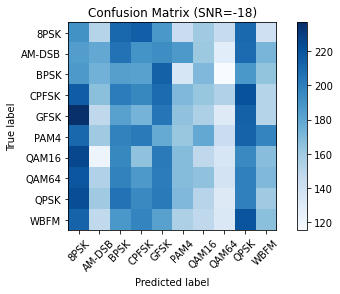


SNR =  -16
Accuracy =  0.09973060949601527
Train Accuracy =  1.0
Validation Accuracy =  0.09760765550239234
Avarege Overall Accuracy =  0.39911275499946924


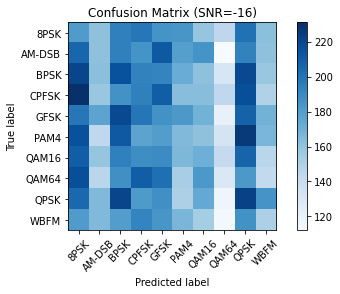


SNR =  -14
Accuracy =  0.10608734009704456
Train Accuracy =  1.0
Validation Accuracy =  0.1015625
Avarege Overall Accuracy =  0.40254994669901484


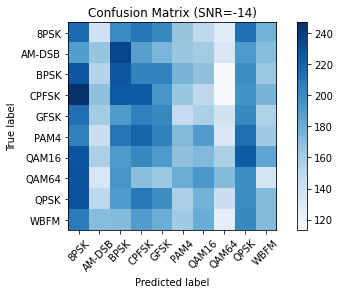


SNR =  -12
Accuracy =  0.10299646174259178
Train Accuracy =  1.0
Validation Accuracy =  0.1050439611291069
Avarege Overall Accuracy =  0.4026801409572329


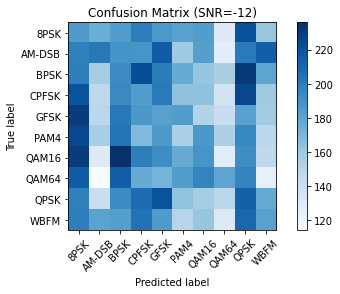


SNR =  -10
Accuracy =  0.11071862236449939
Train Accuracy =  1.0
Validation Accuracy =  0.1156558533145275
Avarege Overall Accuracy =  0.40879149189300895


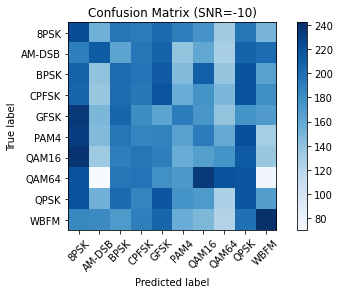


SNR =  -8
Accuracy =  0.12516666666666668
Train Accuracy =  1.0
Validation Accuracy =  0.13470533208606175
Avarege Overall Accuracy =  0.41995733291757614


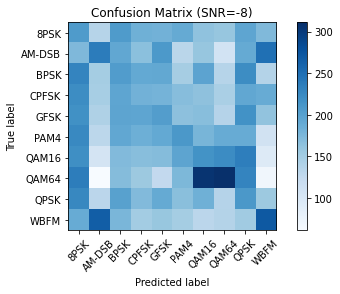


SNR =  -6
Accuracy =  0.14682318905085123
Train Accuracy =  1.0
Validation Accuracy =  0.14511494252873564
Avarege Overall Accuracy =  0.43064604385986227


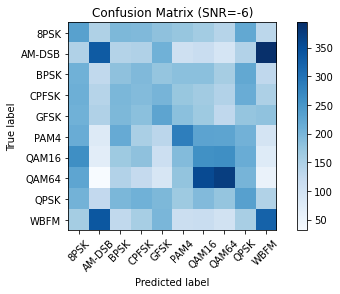


SNR =  -4
Accuracy =  0.18364197530864199
Train Accuracy =  1.0
Validation Accuracy =  0.16826923076923078
Avarege Overall Accuracy =  0.45063706869262427


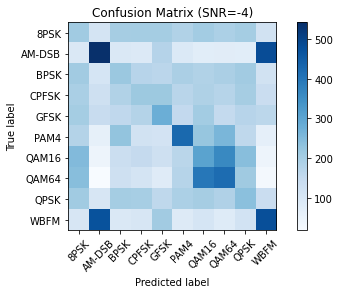


SNR =  -2
Accuracy =  0.22734331669439822
Train Accuracy =  1.0
Validation Accuracy =  0.24123222748815165
Avarege Overall Accuracy =  0.4895251813941832


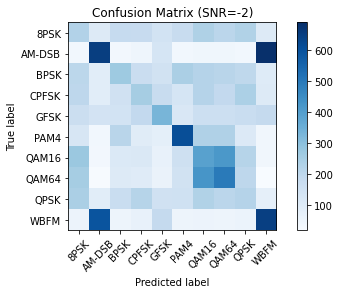


SNR =  0
Accuracy =  0.2789294295133263
Train Accuracy =  1.0
Validation Accuracy =  0.2815026153114598
Avarege Overall Accuracy =  0.5201440149415953


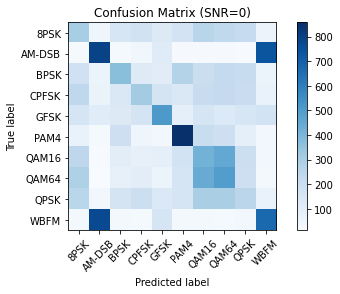


SNR =  2
Accuracy =  0.3454193191253806
Train Accuracy =  1.0
Validation Accuracy =  0.3562888570062171
Avarege Overall Accuracy =  0.5672360587105326


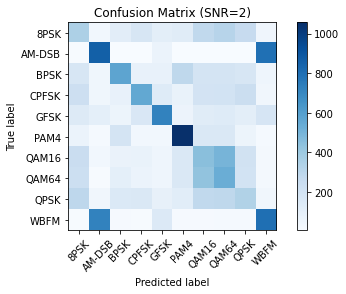


SNR =  4
Accuracy =  0.4138873396542108
Train Accuracy =  1.0
Validation Accuracy =  0.40795781399808245
Avarege Overall Accuracy =  0.6072817178840978


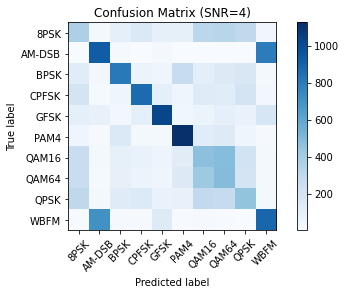


SNR =  6
Accuracy =  0.48155794877517993
Train Accuracy =  1.0
Validation Accuracy =  0.5002386634844869
Avarege Overall Accuracy =  0.6605988707532223


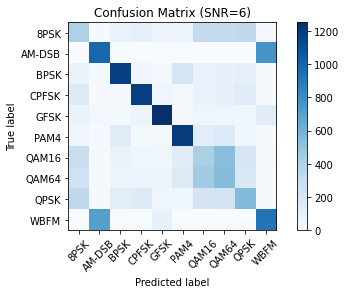


SNR =  8
Accuracy =  0.530558950994555
Train Accuracy =  1.0
Validation Accuracy =  0.5248721524872152
Avarege Overall Accuracy =  0.6851437011605901


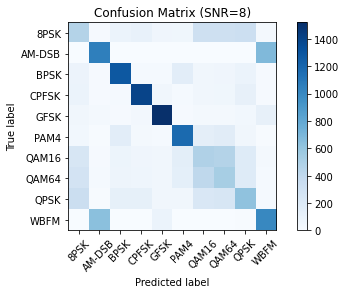


SNR =  10
Accuracy =  0.5494566422710135
Train Accuracy =  1.0
Validation Accuracy =  0.5438265786993403
Avarege Overall Accuracy =  0.6977610736567845


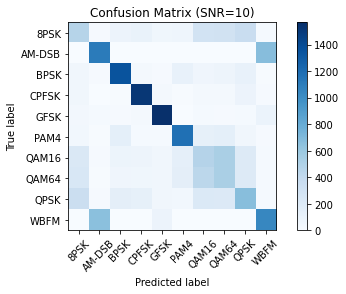


SNR =  12
Accuracy =  0.5540276147353123
Train Accuracy =  1.0
Validation Accuracy =  0.5548011639185257
Avarege Overall Accuracy =  0.7029429262179461


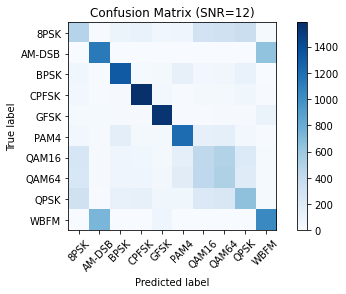


SNR =  14
Accuracy =  0.5681741856039404
Train Accuracy =  1.0
Validation Accuracy =  0.563468992248062
Avarege Overall Accuracy =  0.7105477259506675


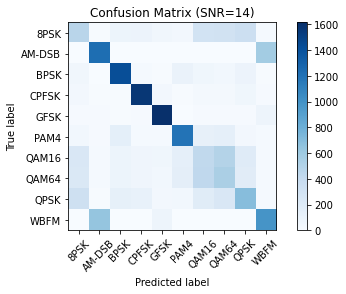


SNR =  16
Accuracy =  0.5660012166122877
Train Accuracy =  1.0
Validation Accuracy =  0.5739557739557739
Avarege Overall Accuracy =  0.7133189968560205


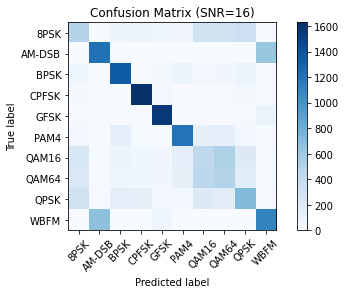


SNR =  18
Accuracy =  0.5715465506799537
Train Accuracy =  1.0
Validation Accuracy =  0.5802348336594912
Avarege Overall Accuracy =  0.7172604614464816


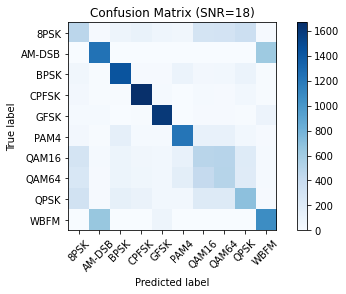

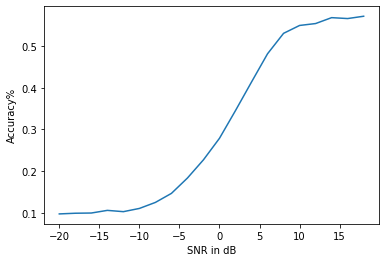

In [18]:
acc = decision_tree_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr)
snr_plot(acc, snrs)


SNR =  -20
Accuracy =  0.10229980604045442
Train Accuracy =  1.0
Validation Accuracy =  0.10460048426150122
Avarege Overall Accuracy =  0.40230009676731854


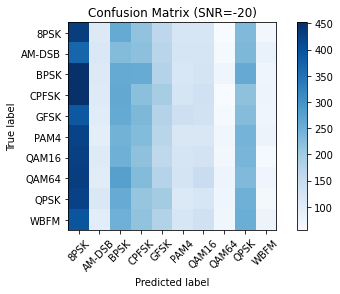


SNR =  -18
Accuracy =  0.1037136917804371
Train Accuracy =  1.0
Validation Accuracy =  0.09185606060606061
Avarege Overall Accuracy =  0.3985232507954992


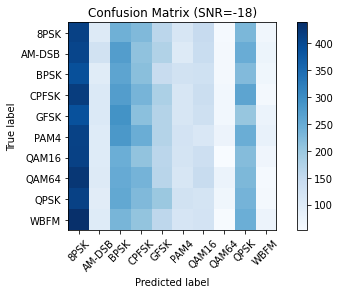


SNR =  -16
Accuracy =  0.10792457065888428
Train Accuracy =  1.0
Validation Accuracy =  0.09808612440191387
Avarege Overall Accuracy =  0.402003565020266


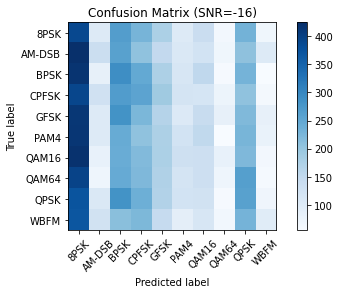


SNR =  -14
Accuracy =  0.10983678870754301
Train Accuracy =  1.0
Validation Accuracy =  0.11397058823529412
Avarege Overall Accuracy =  0.40793579231427907


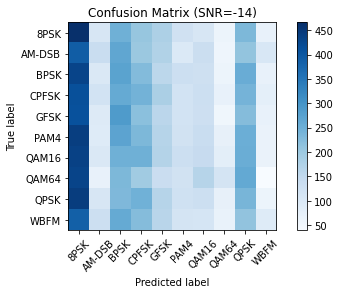


SNR =  -12
Accuracy =  0.11897390535161433
Train Accuracy =  1.0
Validation Accuracy =  0.12401665895418787
Avarege Overall Accuracy =  0.41433018810193406


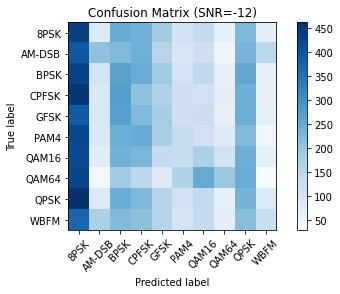


SNR =  -10
Accuracy =  0.14212385473010267
Train Accuracy =  1.0
Validation Accuracy =  0.13587212035731078
Avarege Overall Accuracy =  0.42599865836247114


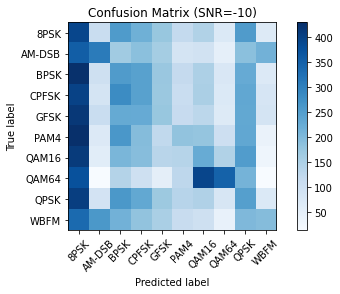


SNR =  -8
Accuracy =  0.18422222222222223
Train Accuracy =  1.0
Validation Accuracy =  0.18475210477081386
Avarege Overall Accuracy =  0.4563247756643454


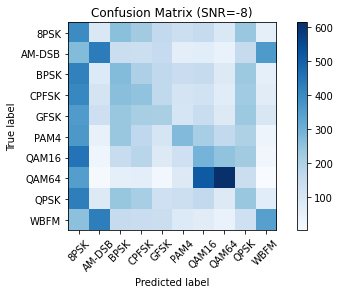


SNR =  -6
Accuracy =  0.24034716813174586
Train Accuracy =  1.0
Validation Accuracy =  0.24568965517241378
Avarege Overall Accuracy =  0.4953456077680532


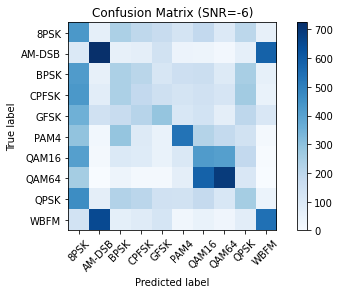


SNR =  -4
Accuracy =  0.31801146384479717
Train Accuracy =  1.0
Validation Accuracy =  0.3091346153846154
Avarege Overall Accuracy =  0.5423820264098042


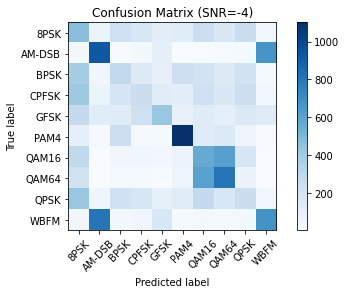


SNR =  -2
Accuracy =  0.37792567942318356
Train Accuracy =  1.0
Validation Accuracy =  0.3990521327014218
Avarege Overall Accuracy =  0.5923259373748685


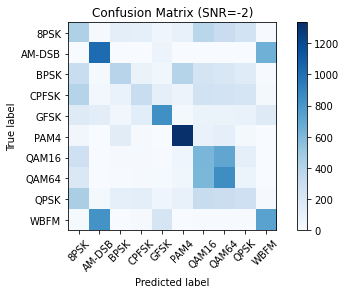


SNR =  0
Accuracy =  0.4765044420852657
Train Accuracy =  1.0
Validation Accuracy =  0.468378506894912
Avarege Overall Accuracy =  0.648294316326726


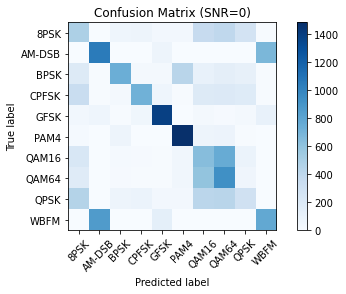


SNR =  2
Accuracy =  0.5820094104622198
Train Accuracy =  1.0
Validation Accuracy =  0.5901482544237207
Avarege Overall Accuracy =  0.7240525549619802


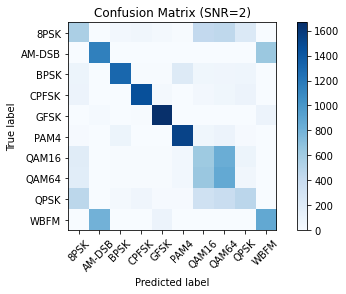


SNR =  4
Accuracy =  0.6427774679308421
Train Accuracy =  1.0
Validation Accuracy =  0.6241610738255033
Avarege Overall Accuracy =  0.7556461805854485


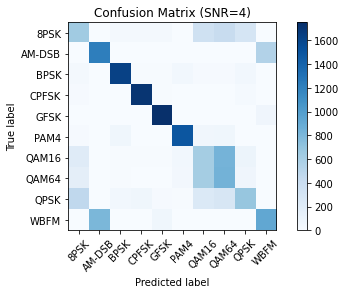


SNR =  6
Accuracy =  0.6839462083589085
Train Accuracy =  1.0
Validation Accuracy =  0.6806682577565633
Avarege Overall Accuracy =  0.7882048220384906


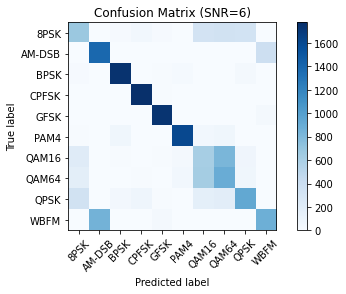


SNR =  8
Accuracy =  0.7014668296477387
Train Accuracy =  1.0
Validation Accuracy =  0.6959553695955369
Avarege Overall Accuracy =  0.7991407330810919


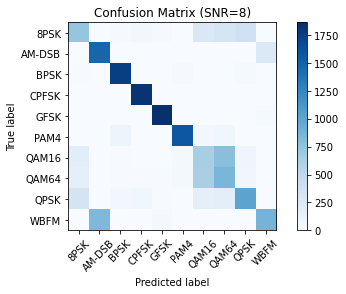


SNR =  10
Accuracy =  0.704868041694389
Train Accuracy =  1.0
Validation Accuracy =  0.7153628652214892
Avarege Overall Accuracy =  0.806743635638626


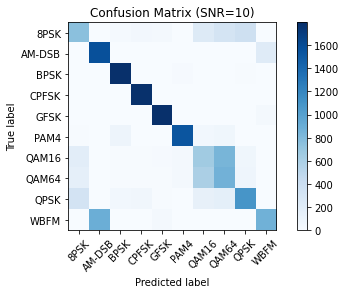


SNR =  12
Accuracy =  0.7056850578567835
Train Accuracy =  0.9999750305875302
Validation Accuracy =  0.6973811833171678
Avarege Overall Accuracy =  0.8010137572538273


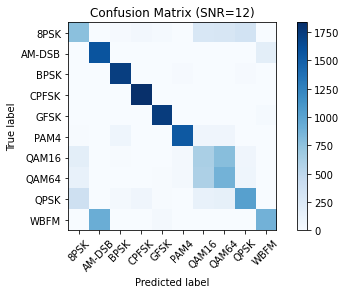


SNR =  14
Accuracy =  0.7151013097503638
Train Accuracy =  1.0
Validation Accuracy =  0.7063953488372093
Avarege Overall Accuracy =  0.8071655528625244


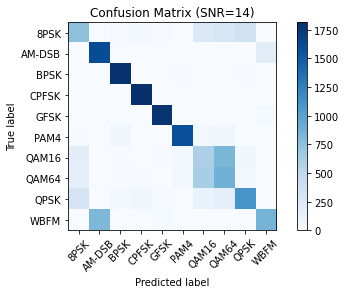


SNR =  16
Accuracy =  0.7088425593098491
Train Accuracy =  1.0
Validation Accuracy =  0.7174447174447175
Avarege Overall Accuracy =  0.8087624255848554


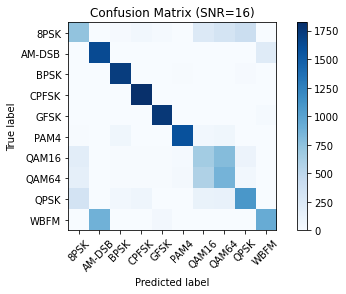


SNR =  18
Accuracy =  0.7133182844243793
Train Accuracy =  1.0
Validation Accuracy =  0.7045009784735812
Avarege Overall Accuracy =  0.8059397542993202


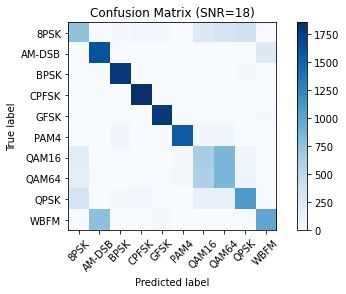

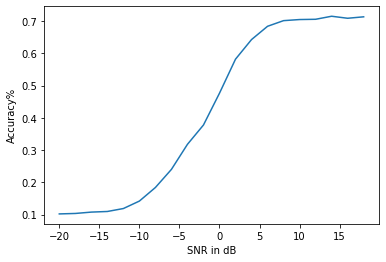

In [19]:
acc = random_forest_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr)
snr_plot(acc, snrs)

Model summary for this input: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 128)            16512     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 19,082
Trainable params: 19,082
Non-trainable params: 0
_________________________________________________________________
Start training for model: 
Epoch 1/100
780/780 - 4s - loss: 2.0225 - accuracy: 0.2383 - val_loss: 1.8540 - val_accuracy: 0.2860
INFO:tensorflow:Assets written to: /content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/data/assets
Epoch 2/100
780/780 - 2s - loss: 1.7927 - accuracy: 0.3033 - val_loss: 1.7568 - val_accuracy: 0

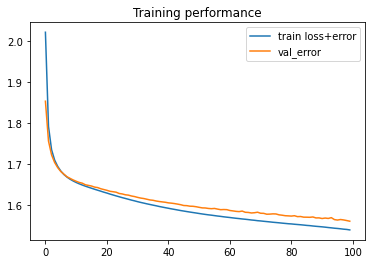

<Figure size 432x288 with 0 Axes>

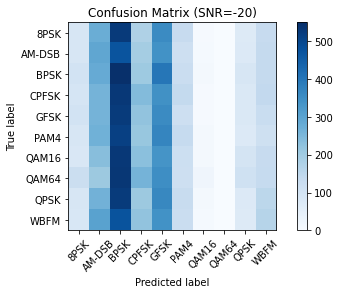


SNR =  -18
Accuracy =  0.10590482611382662
Train Accuracy =  0.12232782059916686
Validation Accuracy =  0.11079545454545454
Avarege Overall Accuracy =  0.11300936708614934


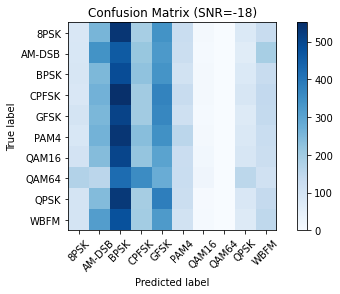


SNR =  -16
Accuracy =  0.11460321023683916
Train Accuracy =  0.1277811034620373
Validation Accuracy =  0.12631578947368421
Avarege Overall Accuracy =  0.12290003439085356


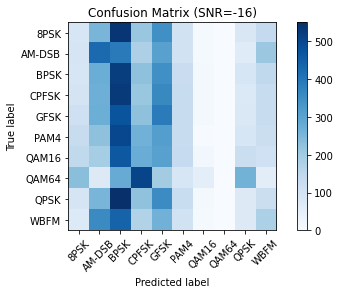


SNR =  -14
Accuracy =  0.13183722981914425
Train Accuracy =  0.1404454747026809
Validation Accuracy =  0.125
Avarege Overall Accuracy =  0.13242756817394172


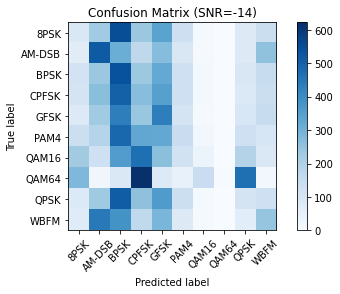


SNR =  -12
Accuracy =  0.15712074303405574
Train Accuracy =  0.173152876657191
Validation Accuracy =  0.16381304951411382
Avarege Overall Accuracy =  0.16469555640178687


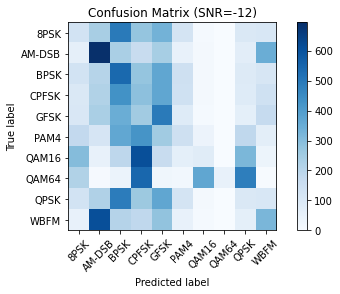


SNR =  -10
Accuracy =  0.2189535268793465
Train Accuracy =  0.23951704188152434
Validation Accuracy =  0.22331922896097792
Avarege Overall Accuracy =  0.22726326590728294


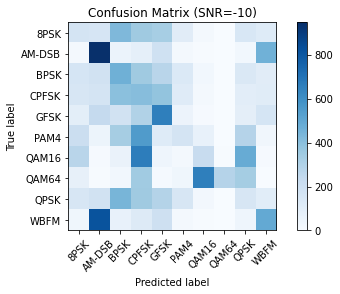


SNR =  -8
Accuracy =  0.31633333333333336
Train Accuracy =  0.33565802016958507
Validation Accuracy =  0.3372310570626754
Avarege Overall Accuracy =  0.3297408035218646


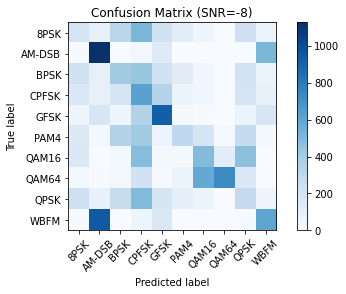


SNR =  -6
Accuracy =  0.4134305107377323
Train Accuracy =  0.4309930392107767
Validation Accuracy =  0.40565134099616856
Avarege Overall Accuracy =  0.4166916303148925


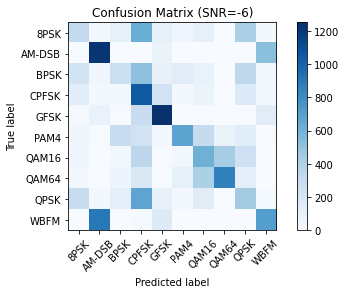


SNR =  -4
Accuracy =  0.4729938271604938
Train Accuracy =  0.48956657280772325
Validation Accuracy =  0.45528846153846153
Avarege Overall Accuracy =  0.47261628716889287


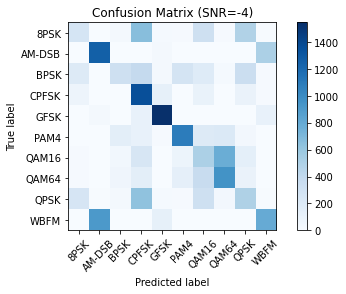


SNR =  -2
Accuracy =  0.4812534664448142
Train Accuracy =  0.4957852483692925
Validation Accuracy =  0.4900473933649289
Avarege Overall Accuracy =  0.4890287027263452


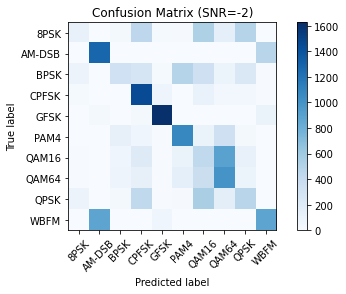


SNR =  0
Accuracy =  0.49298765156171426
Train Accuracy =  0.505
Validation Accuracy =  0.4983357108892059
Avarege Overall Accuracy =  0.49877445415030675


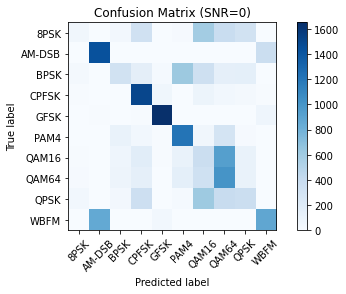


SNR =  2
Accuracy =  0.49476889011901465
Train Accuracy =  0.5088595522537898
Validation Accuracy =  0.5007173601147776
Avarege Overall Accuracy =  0.501448600829194


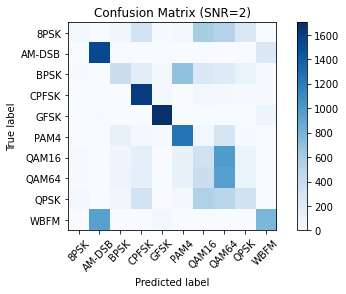


SNR =  4
Accuracy =  0.5054656999442275
Train Accuracy =  0.5163565426170468
Validation Accuracy =  0.5095877277085331
Avarege Overall Accuracy =  0.5104699900899358


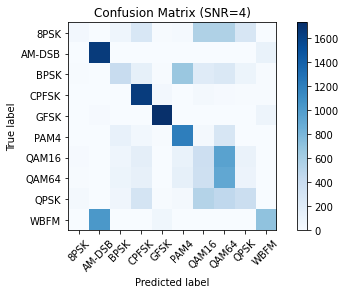


SNR =  6
Accuracy =  0.5179398471067462
Train Accuracy =  0.5197078831532613
Validation Accuracy =  0.5145584725536992
Avarege Overall Accuracy =  0.5174020676045689


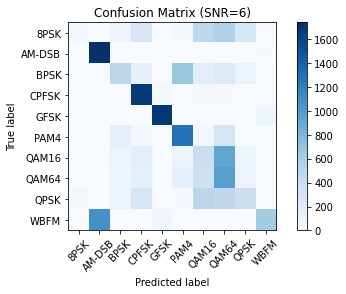


SNR =  8
Accuracy =  0.5217246360706745
Train Accuracy =  0.5175277910215553
Validation Accuracy =  0.5378893537889354
Avarege Overall Accuracy =  0.5257139269603884


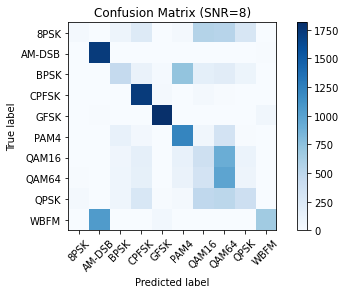


SNR =  10
Accuracy =  0.5156353958749168
Train Accuracy =  0.5220370463330154
Validation Accuracy =  0.5207351555136663
Avarege Overall Accuracy =  0.5194691992405329


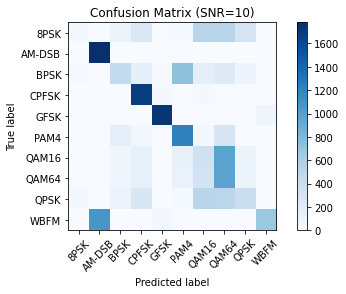


SNR =  12
Accuracy =  0.5186427413494327
Train Accuracy =  0.5208869135309246
Validation Accuracy =  0.5252182347235693
Avarege Overall Accuracy =  0.5215826298679755


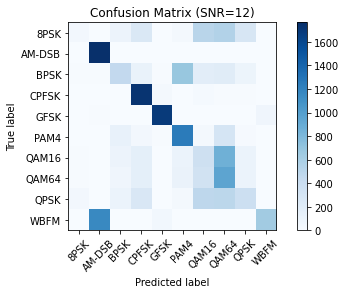


SNR =  14
Accuracy =  0.5275383409828724
Train Accuracy =  0.5235088594958822
Validation Accuracy =  0.5208333333333334
Avarege Overall Accuracy =  0.5239601779373627


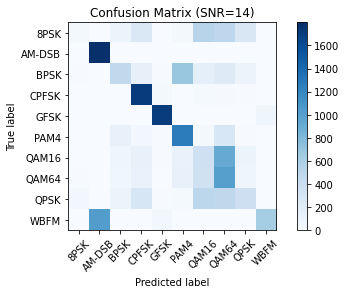


SNR =  16
Accuracy =  0.5214842669910966
Train Accuracy =  0.5207361717065343
Validation Accuracy =  0.5066339066339066
Avarege Overall Accuracy =  0.5162847817771792


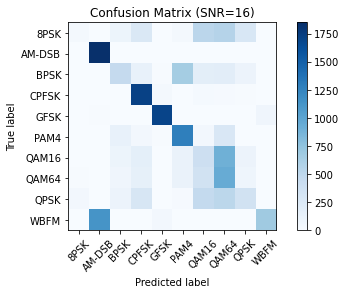


SNR =  18
Accuracy =  0.5234818036667951
Train Accuracy =  0.5240368909104617
Validation Accuracy =  0.5176125244618396
Avarege Overall Accuracy =  0.5217104063463655


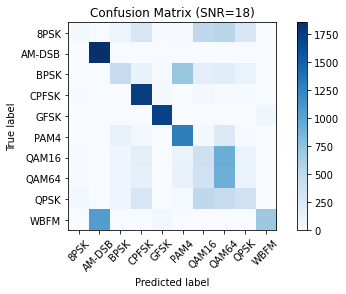

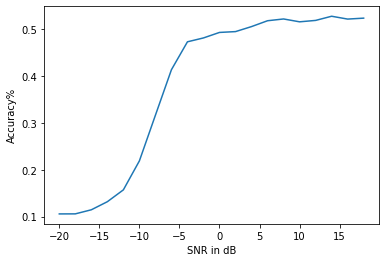

In [20]:
full_dense(trainX, trainY_mod10, valX, valY_mod10, testX)

Model summary for this input: 
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 2, 126)        256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 2, 126)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 1, 124)        6160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 1, 124)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense1 (Dense)         

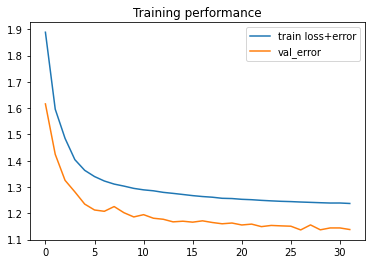

<Figure size 432x288 with 0 Axes>

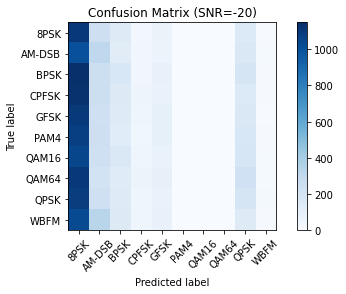


SNR =  -18
Accuracy =  0.10972526546435193
Train Accuracy =  0.11304846716056774
Validation Accuracy =  0.10416666666666667
Avarege Overall Accuracy =  0.10898013309719545


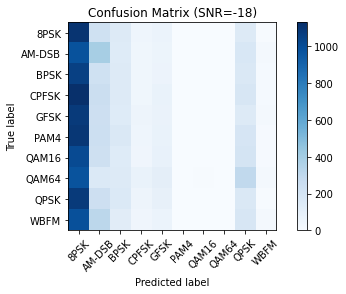


SNR =  -16
Accuracy =  0.11493994836682007
Train Accuracy =  0.11892646912102164
Validation Accuracy =  0.12057416267942583
Avarege Overall Accuracy =  0.11814686005575585


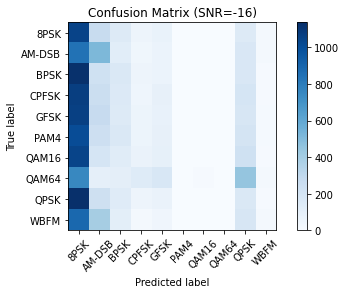


SNR =  -14
Accuracy =  0.12764666960741067
Train Accuracy =  0.13439830679298528
Validation Accuracy =  0.1401654411764706
Avarege Overall Accuracy =  0.13407013919228886


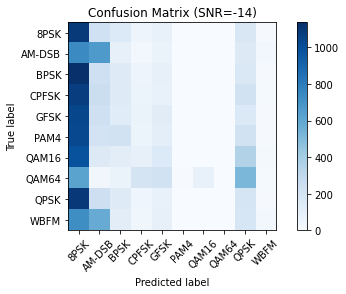


SNR =  -12
Accuracy =  0.15037593984962405
Train Accuracy =  0.1538326079847048
Validation Accuracy =  0.16335030078667284
Avarege Overall Accuracy =  0.1558529495403339


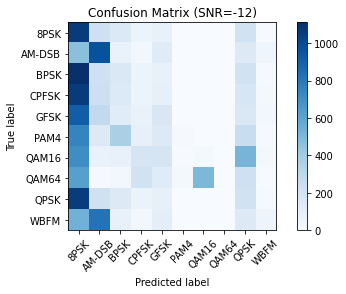


SNR =  -10
Accuracy =  0.21282702285020422
Train Accuracy =  0.21690353414664823
Validation Accuracy =  0.20874471086036672
Avarege Overall Accuracy =  0.21282508928573973


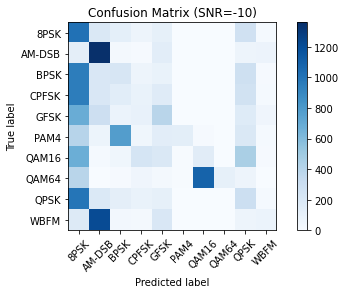


SNR =  -8
Accuracy =  0.35483333333333333
Train Accuracy =  0.3589885103607446
Validation Accuracy =  0.36108512628624884
Avarege Overall Accuracy =  0.35830232332677553


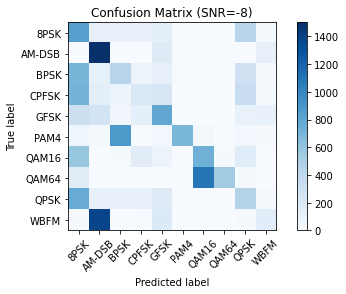


SNR =  -6
Accuracy =  0.5284855902970959
Train Accuracy =  0.5334768891782262
Validation Accuracy =  0.5340038314176245
Avarege Overall Accuracy =  0.5319887702976489


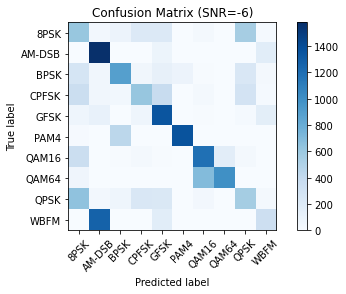


SNR =  -4
Accuracy =  0.6317239858906526
Train Accuracy =  0.6409644006436042
Validation Accuracy =  0.6389423076923076
Avarege Overall Accuracy =  0.6372102314088548


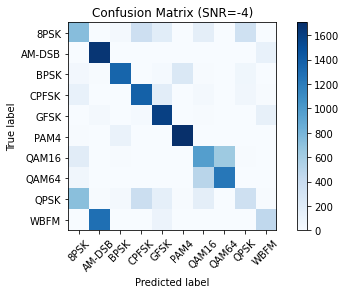


SNR =  -2
Accuracy =  0.6748197448696617
Train Accuracy =  0.6806823883592574
Validation Accuracy =  0.6815165876777252
Avarege Overall Accuracy =  0.6790062403022148


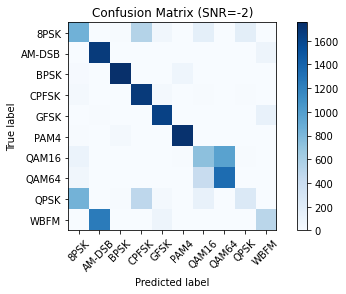


SNR =  0
Accuracy =  0.7013465944012963
Train Accuracy =  0.70725
Validation Accuracy =  0.7184973846885402
Avarege Overall Accuracy =  0.7090313263632789


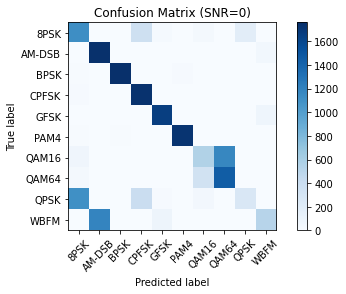


SNR =  2
Accuracy =  0.7163022419042347
Train Accuracy =  0.7220158618612589
Validation Accuracy =  0.711142993782879
Avarege Overall Accuracy =  0.7164870325161242


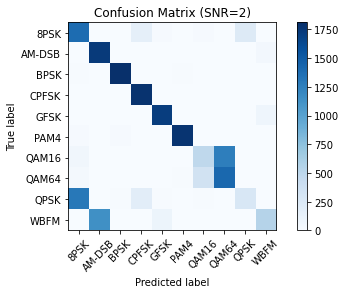


SNR =  4
Accuracy =  0.7207473508087004
Train Accuracy =  0.7302170868347339
Validation Accuracy =  0.7152444870565676
Avarege Overall Accuracy =  0.7220696415666673


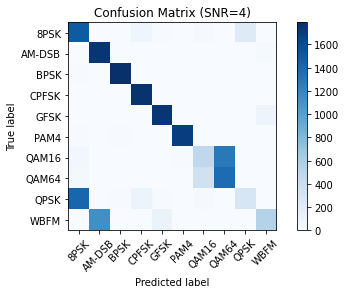


SNR =  6
Accuracy =  0.7295351821884939
Train Accuracy =  0.7294917967186875
Validation Accuracy =  0.7274463007159905
Avarege Overall Accuracy =  0.7288244265410574


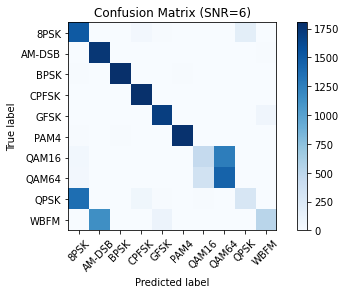


SNR =  8
Accuracy =  0.7325258362040227
Train Accuracy =  0.7300946023939173
Validation Accuracy =  0.7294281729428173
Avarege Overall Accuracy =  0.7306828705135858


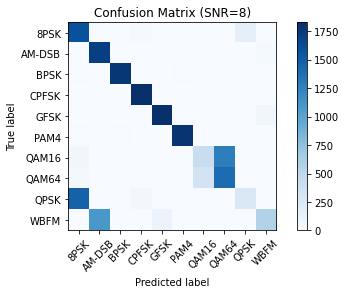


SNR =  10
Accuracy =  0.727156797516079
Train Accuracy =  0.7321168616033331
Validation Accuracy =  0.7120640904806786
Avarege Overall Accuracy =  0.723779249866697


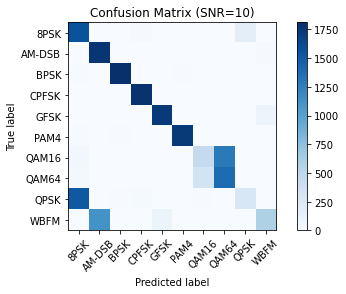


SNR =  12
Accuracy =  0.7255855553692213
Train Accuracy =  0.7325026842118405
Validation Accuracy =  0.7308438409311349
Avarege Overall Accuracy =  0.7296440268373989


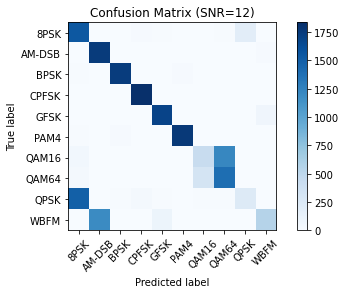


SNR =  14
Accuracy =  0.730493675137132
Train Accuracy =  0.7297479411030696
Validation Accuracy =  0.7243217054263565
Avarege Overall Accuracy =  0.7281877738888527


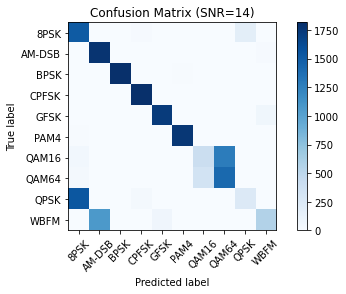


SNR =  16
Accuracy =  0.7271470441851463
Train Accuracy =  0.7308810992427661
Validation Accuracy =  0.7395577395577395
Avarege Overall Accuracy =  0.732528627661884


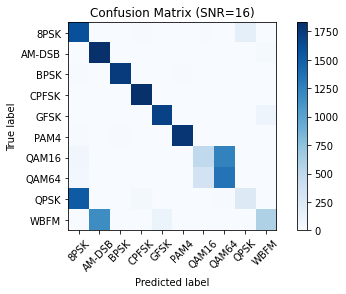


SNR =  18
Accuracy =  0.7301657215217751
Train Accuracy =  0.7300278943532782
Validation Accuracy =  0.7289628180039139
Avarege Overall Accuracy =  0.729718811292989


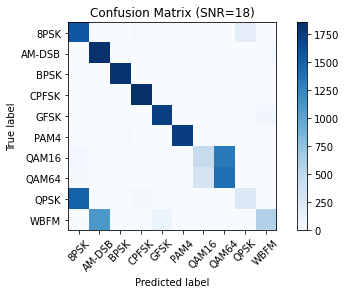

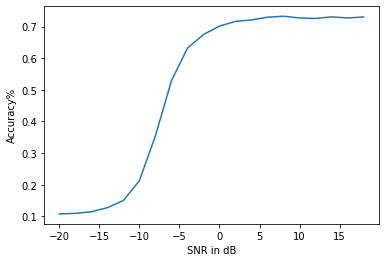

In [23]:
CnnModel(trainX,trainY_mod10,valX,valY_mod10,testX,testY_mod10)